## Introduction

[LendingClub](https://www.lendingclub.com/) is the world's largest peer-to-peer lending platform. Until recently (through the end of 2018), LendingClub published a public dataset of all loans issued since the company's launch in 2007. I'm accessing the dataset [via Kaggle](https://www.kaggle.com/wordsforthewise/lending-club).

In [2]:
import pandas as pd

loans_raw = pd.read_csv(
    "../input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv",
    low_memory=False,
)

loans_raw.shape

(2260701, 151)

## Data cleaning

In [3]:
dictionary_df = pd.read_excel("../input/lcdatadictionary/LCDataDictionary.xlsx")

# Drop blank rows, strip white space, convert to Python dictionary, fix one key name
dictionary_df.dropna(axis="index", inplace=True)
dictionary_df = dictionary_df.applymap(lambda x: x.strip())
dictionary_df.set_index("LoanStatNew", inplace=True)
dictionary = dictionary_df["Description"].to_dict()
dictionary["verification_status_joint"] = dictionary.pop("verified_status_joint")

# Print in order of dataset columns (which makes more sense than dictionary's order)
for col in loans_raw.columns:
    print(f"•{col}: {dictionary[col]}")

# Hiding the output because it's quite a few lines, but feel free to take a peek by
# clicking the "Output" button

•id: A unique LC assigned ID for the loan listing.
•member_id: A unique LC assigned Id for the borrower member.
•loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
•funded_amnt: The total amount committed to that loan at that point in time.
•funded_amnt_inv: The total amount committed by investors for that loan at that point in time.
•term: The number of payments on the loan. Values are in months and can be either 36 or 60.
•int_rate: Interest Rate on the loan
•installment: The monthly payment owed by the borrower if the loan originates.
•grade: LC assigned loan grade
•sub_grade: LC assigned loan subgrade
•emp_title: The job title supplied by the Borrower when applying for the loan.*
•emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
•home_ownership: The home owner

In [4]:
cols_for_output = ["term", "installment", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee"]

In [5]:
loans_raw["emp_title"].nunique()

512694

In [6]:
cols_to_drop = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "int_rate", "grade", "sub_grade", "emp_title", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "policy_code", "hardship_flag", "hardship_type", "hardship_reason", "hardship_status", "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date", "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status", "orig_projected_additional_accrued_interest", "hardship_payoff_balance_amount", "hardship_last_payment_amount", "disbursement_method", "debt_settlement_flag", "debt_settlement_flag_date", "settlement_status", "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term"]

loans = loans_raw.drop(columns=cols_to_drop)

In [7]:
loans.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off                                             268559
Current                                                 878317
Default                                                     40
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1076751
In Grace Period                                           8436
Late (16-30 days)                                         4349
Late (31-120 days)                                       21467
Name: loan_status, dtype: int64

In [8]:
credit_policy = "Does not meet the credit policy. Status:"
len_credit_policy = len(credit_policy)
remove_credit_policy = (
    lambda status: status[len_credit_policy:]
    if credit_policy in str(status)
    else status
)
loans["loan_status"] = loans["loan_status"].map(remove_credit_policy)

rows_to_drop = loans[
    (loans["loan_status"] != "Charged Off") & (loans["loan_status"] != "Fully Paid")
].index
loans.drop(index=rows_to_drop, inplace=True)

loans.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off     269320
Fully Paid     1078739
Name: loan_status, dtype: int64

In [9]:
loans[cols_for_output].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348059 entries, 0 to 2260697
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   term                     1348059 non-null  object 
 1   installment              1348059 non-null  float64
 2   total_rec_prncp          1348059 non-null  float64
 3   total_rec_int            1348059 non-null  float64
 4   total_rec_late_fee       1348059 non-null  float64
 5   recoveries               1348059 non-null  float64
 6   collection_recovery_fee  1348059 non-null  float64
dtypes: float64(6), object(1)
memory usage: 82.3+ MB


In [10]:
loans.groupby("term")["term"].count()

term
 36 months    1023181
 60 months     324878
Name: term, dtype: int64

In [11]:
onehot_cols = ["term"]

loans["term"] = loans["term"].map(lambda term_str: term_str.strip())

extract_num = lambda term_str: float(term_str[:2])
loans["term_num"] = loans["term"].map(extract_num)
cols_for_output.remove("term")
cols_for_output.append("term_num")

In [12]:
received = (
    loans["total_rec_prncp"]
    + loans["total_rec_int"]
    + loans["total_rec_late_fee"]
    + loans["recoveries"]
    - loans["collection_recovery_fee"]
)
expected = loans["installment"] * loans["term_num"]
loans["fraction_recovered"] = received / expected

loans.groupby("loan_status")["fraction_recovered"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400162,0.219020,0.000000,0.224463,0.367554,0.550924,2.410680
Fully Paid,1078739.0,0.932705,0.100455,0.506053,0.897912,0.960100,0.997612,60.932353


In [13]:
import numpy as np

loans["fraction_recovered"] = np.where(
    (loans["loan_status"] == "Fully Paid") | (loans["fraction_recovered"] > 1.0),
    1.0,
    loans["fraction_recovered"],
)
loans.groupby("loan_status")["fraction_recovered"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400152,0.218971,0.0,0.224463,0.367554,0.550924,1.0
Fully Paid,1078739.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0


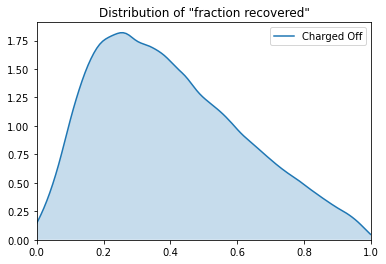

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.kdeplot(
    data=loans["fraction_recovered"][loans["loan_status"] == "Charged Off"],
    label="Charged Off",
    shade=True,
)
plt.axis(xmin=0, xmax=1)
plt.title('Distribution of "fraction recovered"')
plt.show()

In [15]:
loans.drop(columns=cols_for_output, inplace=True)
loans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1348059 non-null  float64
 1   term                                 1348059 non-null  object 
 2   emp_length                           1269514 non-null  object 
 3   home_ownership                       1348059 non-null  object 
 4   annual_inc                           1348055 non-null  float64
 5   verification_status                  1348059 non-null  object 
 6   issue_d                              1348059 non-null  object 
 7   loan_status                          1348059 non-null  object 
 8   purpose                              1348059 non-null  object 
 9   dti                                  1347685 non-null  float64
 10  delinq_2yrs                          1348030 non-null  float64
 11

In [16]:
negative_mark_cols = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq", "mths_since_recent_revol_delinq", "sec_app_mths_since_last_major_derog"]
joint_cols = ["annual_inc_joint", "dti_joint", "verification_status_joint", "revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog"]
confusing_cols = ["open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m"]

In [17]:
loans["issue_d"] = loans["issue_d"].astype("datetime64[ns]")

# Check date range of confusing columns
loans[confusing_cols + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count                 464325
min      2015-12-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [18]:
# Compare to all entries from Dec 2015 onward
loans["issue_d"][loans["issue_d"] >= np.datetime64("2015-12-01")].agg(
    ["count", "min", "max"]
)

count                 557708
min      2015-12-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [19]:
new_metric_cols = confusing_cols

In [20]:
mths_since_last_cols = [
    col_name
    for col_name in loans.columns
    if "mths_since" in col_name or "mo_sin_rcnt" in col_name
]
mths_since_old_cols = [
    col_name for col_name in loans.columns if "mo_sin_old" in col_name
]

for col_name in mths_since_last_cols:
    loans[col_name] = [
        0.0 if pd.isna(months) else 1 / 1 if months == 0 else 1 / months
        for months in loans[col_name]
    ]
loans.loc[:, mths_since_old_cols].fillna(0, inplace=True)

# Rename inverse columns
rename_mapper = {}
for col_name in mths_since_last_cols:
    rename_mapper[col_name] = col_name.replace("mths_since", "inv_mths_since").replace(
        "mo_sin_rcnt", "inv_mo_sin_rcnt"
    )
loans.rename(columns=rename_mapper, inplace=True)


def replace_list_value(l, old_value, new_value):
    i = l.index(old_value)
    l.pop(i)
    l.insert(i, new_value)


replace_list_value(new_metric_cols, "mths_since_rcnt_il", "inv_mths_since_rcnt_il")
replace_list_value(
    joint_cols,
    "sec_app_mths_since_last_major_derog",
    "sec_app_inv_mths_since_last_major_derog",
)

In [21]:
loans.groupby("application_type")["application_type"].count()

application_type
Individual    1322259
Joint App       25800
Name: application_type, dtype: int64

In [22]:
joint_loans = loans[:][loans["application_type"] == "Joint App"]
joint_loans[joint_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25800 entries, 2 to 2260663
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   annual_inc_joint                         25800 non-null  float64
 1   dti_joint                                25797 non-null  float64
 2   verification_status_joint                25595 non-null  object 
 3   revol_bal_joint                          18629 non-null  float64
 4   sec_app_fico_range_low                   18630 non-null  float64
 5   sec_app_fico_range_high                  18630 non-null  float64
 6   sec_app_earliest_cr_line                 18630 non-null  object 
 7   sec_app_inq_last_6mths                   18630 non-null  float64
 8   sec_app_mort_acc                         18630 non-null  float64
 9   sec_app_open_acc                         18630 non-null  float64
 10  sec_app_revol_util                       183

In [23]:
joint_new_metric_cols = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]
joint_loans[joint_new_metric_cols + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count                  18301
min      2017-03-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [24]:
# Check without `sec_app_revol_util` column
joint_new_metric_cols_2 = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]
joint_loans[joint_new_metric_cols_2 + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
    ["count", "min", "max"]
)

count                  18629
min      2017-03-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [25]:
joint_loans["issue_d"].agg(["count", "min", "max"])

count                  25800
min      2015-10-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [26]:
onehot_cols.append("application_type")

# Fill joint columns in individual applications
for joint_col, indiv_col in zip(
    ["annual_inc_joint", "dti_joint", "verification_status_joint"],
    ["annual_inc", "dti", "verification_status"],
):
    loans[joint_col] = [
        joint_val if app_type == "Joint App" else indiv_val
        for app_type, joint_val, indiv_val in zip(
            loans["application_type"], loans[joint_col], loans[indiv_col]
        )
    ]

loans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                                   Non-Null Count    Dtype         
---  ------                                   --------------    -----         
 0   loan_amnt                                1348059 non-null  float64       
 1   term                                     1348059 non-null  object        
 2   emp_length                               1269514 non-null  object        
 3   home_ownership                           1348059 non-null  object        
 4   annual_inc                               1348055 non-null  float64       
 5   verification_status                      1348059 non-null  object        
 6   issue_d                                  1348059 non-null  datetime64[ns]
 7   loan_status                              1348059 non-null  object        
 8   purpose                                  1348059 non-null  object        
 9   dti          

In [27]:
cols_to_search = [
    col for col in loans.columns if col not in new_metric_cols + joint_new_metric_cols
]
loans.dropna(axis="index", subset=cols_to_search).shape

(1110171, 97)

In [28]:
loans.dropna(axis="index", subset=cols_to_search, inplace=True)

In [29]:
loans[["earliest_cr_line", "sec_app_earliest_cr_line"]]

,earliest_cr_line,sec_app_earliest_cr_line
0,Aug-2003,NaN
1,Dec-1999,NaN
2,Aug-2000,NaN
4,Jun-1998,NaN
5,Oct-1987,NaN
...,...,...
2260688,Jul-2004,NaN
2260690,Mar-2002,NaN
2260691,Jun-2011,NaN
2260692,Aug-1997,NaN


In [30]:
def get_credit_history_age(col_name):
    earliest_cr_line_date = loans[col_name].astype("datetime64[ns]")
    cr_hist_age_delta = loans["issue_d"] - earliest_cr_line_date
    MINUTES_PER_MONTH = int(365.25 / 12 * 24 * 60)
    cr_hist_age_months = cr_hist_age_delta / np.timedelta64(MINUTES_PER_MONTH, "m")
    return cr_hist_age_months.map(
        lambda value: np.nan if pd.isna(value) else round(value)
    )


cr_hist_age_months = get_credit_history_age("earliest_cr_line")
cr_hist_age_months

0          148
1          192
2          184
4          210
5          338
          ... 
2260688    147
2260690    175
2260691     64
2260692    230
2260697    207
Length: 1110171, dtype: int64

In [31]:
loans["earliest_cr_line"] = cr_hist_age_months
loans["sec_app_earliest_cr_line"] = get_credit_history_age(
    "sec_app_earliest_cr_line"
).astype("Int64")
loans.rename(
    columns={
        "earliest_cr_line": "cr_hist_age_mths",
        "sec_app_earliest_cr_line": "sec_app_cr_hist_age_mths",
    },
    inplace=True,
)
replace_list_value(
    joint_new_metric_cols, "sec_app_earliest_cr_line", "sec_app_cr_hist_age_mths"
)

In [32]:
categorical_cols = ["term", "emp_length", "home_ownership", "verification_status", "purpose", "verification_status_joint"]
for i, col_name in enumerate(categorical_cols):
    print(
        loans.groupby(col_name)[col_name].count(),
        "\n" if i < len(categorical_cols) - 1 else "",
    )

term
36 months    831601
60 months    278570
Name: term, dtype: int64 

emp_length
1 year        76868
10+ years    392883
2 years      106124
3 years       93784
4 years       69031
5 years       72421
6 years       54240
7 years       52229
8 years       53826
9 years       45210
< 1 year      93555
Name: emp_length, dtype: int64 

home_ownership
ANY            250
MORTGAGE    559035
NONE            39
OTHER           40
OWN         114577
RENT        436230
Name: home_ownership, dtype: int64 

verification_status
Not Verified       335350
Source Verified    463153
Verified           311668
Name: verification_status, dtype: int64 

purpose
car                    10754
credit_card           245942
debt_consolidation    653222
educational                1
home_improvement       71089
house                   5720
major_purchase         22901
medical                12302
moving                  7464
other                  60986
renewable_energy         691
small_business         11137
va

In [33]:
loans.drop(
    columns=[
        "verification_status",
        "verification_status_joint",
        "issue_d",
        "loan_status",
    ],
    inplace=True,
)

In [34]:
onehot_cols += ["home_ownership", "purpose"]
ordinal_cols = {
    "emp_length": [
        "< 1 year",
        "1 year",
        "2 years",
        "3 years",
        "4 years",
        "5 years",
        "6 years",
        "7 years",
        "8 years",
        "9 years",
        "10+ years",
    ]
}

In [35]:
loans_1 = loans.drop(columns=new_metric_cols + joint_new_metric_cols)
loans_2 = loans.drop(columns=joint_new_metric_cols)
loans_2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110171 entries, 0 to 2260697
Data columns (total 80 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   loan_amnt                           1110171 non-null  float64
 1   term                                1110171 non-null  object 
 2   emp_length                          1110171 non-null  object 
 3   home_ownership                      1110171 non-null  object 
 4   annual_inc                          1110171 non-null  float64
 5   purpose                             1110171 non-null  object 
 6   dti                                 1110171 non-null  float64
 7   delinq_2yrs                         1110171 non-null  float64
 8   cr_hist_age_mths                    1110171 non-null  int64  
 9   fico_range_low                      1110171 non-null  float64
 10  fico_range_high                     1110171 non-null  float64
 11  inq_last_6m

In [36]:
loans_2["il_util"][loans_2["il_util"].notna()].describe()

count    408722.000000
mean         71.832894
std          22.311439
min           0.000000
25%          59.000000
50%          75.000000
75%          87.000000
max         464.000000
Name: il_util, dtype: float64

In [37]:
query_df = loans[["il_util", "total_bal_il", "total_il_high_credit_limit"]].dropna(
    axis="index", subset=["il_util"]
)
query_df["il_util_compute"] = (
    query_df["total_bal_il"] / query_df["total_il_high_credit_limit"]
).map(lambda x: float(round(x * 100)))
query_df[["il_util", "il_util_compute"]]

,il_util,il_util_compute
0,36.0,36.0
1,73.0,73.0
2,73.0,73.0
4,84.0,84.0
5,99.0,99.0
...,...,...
2260688,52.0,39.0
2260690,50.0,74.0
2260691,47.0,47.0
2260692,79.0,79.0


In [38]:
(query_df["il_util"] == query_df["il_util_compute"]).describe()

count     408722
unique         2
top         True
freq      307589
dtype: object

In [39]:
query_df["compute_diff"] = abs(query_df["il_util"] - query_df["il_util_compute"])
query_df["compute_diff"][query_df["compute_diff"] != 0].describe()

count    101133.000000
mean         14.638684
std          16.409913
min           1.000000
25%           3.000000
50%          10.000000
75%          21.000000
max        1108.000000
Name: compute_diff, dtype: float64

In [40]:
loans["il_util_imputed"] = [
    True if pd.isna(util) & pd.notna(bal) & pd.notna(limit) else False
    for util, bal, limit in zip(
        loans["il_util"], loans["total_bal_il"], loans["total_il_high_credit_limit"]
    )
]
new_metric_onehot_cols = ["il_util_imputed"]
loans["il_util"] = [
    0.0
    if pd.isna(util) & pd.notna(bal) & (limit == 0)
    else float(round(bal / limit * 100))
    if pd.isna(util) & pd.notna(bal) & pd.notna(limit)
    else util
    for util, bal, limit in zip(
        loans["il_util"], loans["total_bal_il"], loans["total_il_high_credit_limit"]
    )
]

loans_2 = loans.drop(columns=joint_new_metric_cols)
loans_2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110171 entries, 0 to 2260697
Data columns (total 81 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   loan_amnt                           1110171 non-null  float64
 1   term                                1110171 non-null  object 
 2   emp_length                          1110171 non-null  object 
 3   home_ownership                      1110171 non-null  object 
 4   annual_inc                          1110171 non-null  float64
 5   purpose                             1110171 non-null  object 
 6   dti                                 1110171 non-null  float64
 7   delinq_2yrs                         1110171 non-null  float64
 8   cr_hist_age_mths                    1110171 non-null  int64  
 9   fico_range_low                      1110171 non-null  float64
 10  fico_range_high                     1110171 non-null  float64
 11  inq_last_6m

In [41]:
loans_2.dropna(axis="index", inplace=True)

loans_3 = loans.dropna(axis="index")
loans_3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14453 entries, 421222 to 2157147
Data columns (total 94 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   loan_amnt                                14453 non-null  float64
 1   term                                     14453 non-null  object 
 2   emp_length                               14453 non-null  object 
 3   home_ownership                           14453 non-null  object 
 4   annual_inc                               14453 non-null  float64
 5   purpose                                  14453 non-null  object 
 6   dti                                      14453 non-null  float64
 7   delinq_2yrs                              14453 non-null  float64
 8   cr_hist_age_mths                         14453 non-null  int64  
 9   fico_range_low                           14453 non-null  float64
 10  fico_range_high                        

## Building the neural networks

In [42]:
import shap

Model:
Epoch 1/100


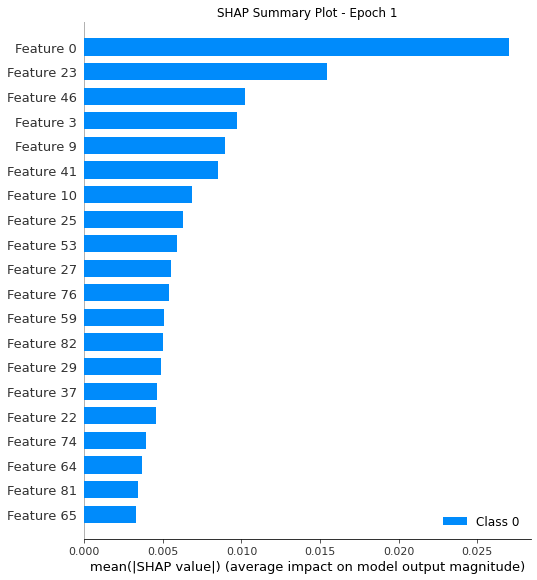

6939/6939 - 17s - loss: 0.0274 - val_loss: 0.0236
Epoch 2/100


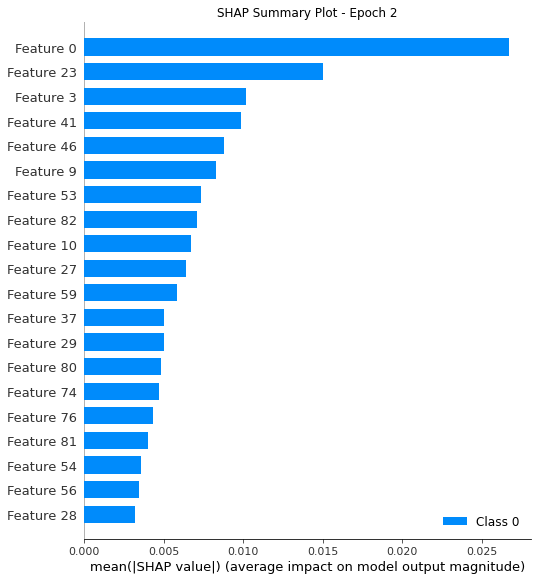

6939/6939 - 16s - loss: 0.0235 - val_loss: 0.0235
Epoch 3/100


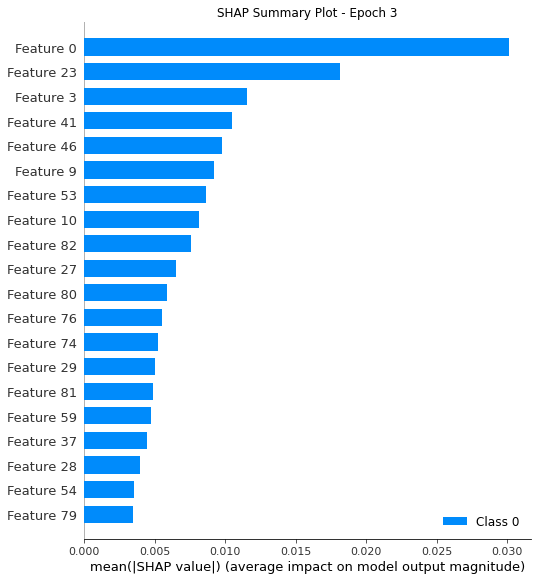

6939/6939 - 17s - loss: 0.0233 - val_loss: 0.0232
Epoch 4/100


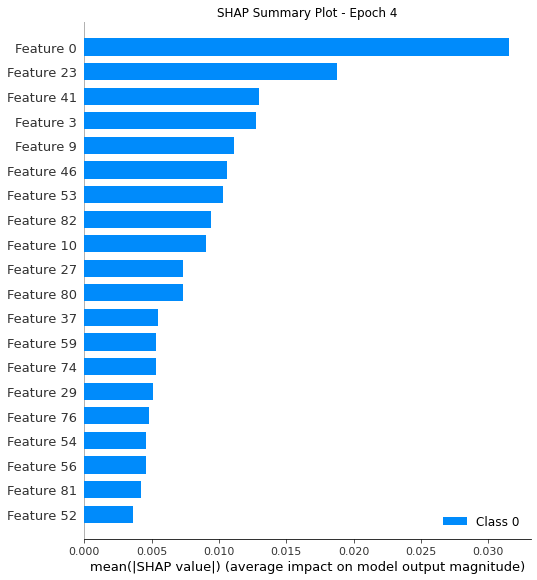

6939/6939 - 16s - loss: 0.0233 - val_loss: 0.0231
Epoch 5/100


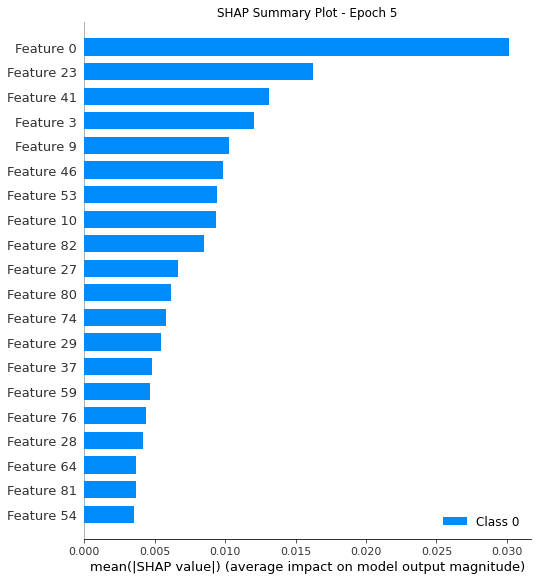

6939/6939 - 16s - loss: 0.0232 - val_loss: 0.0231
Epoch 6/100


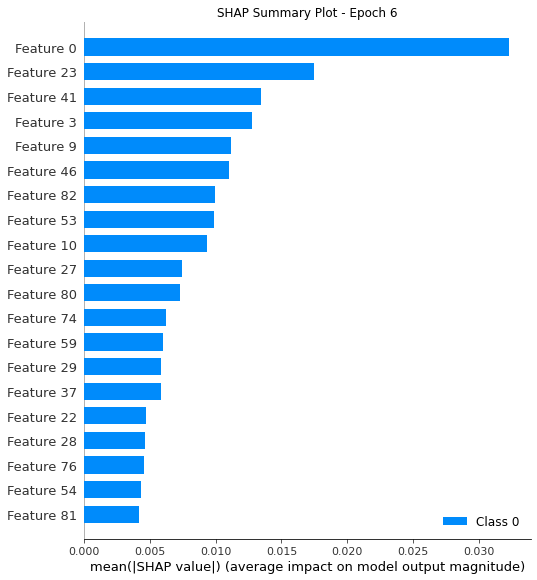

6939/6939 - 16s - loss: 0.0232 - val_loss: 0.0230
Epoch 7/100


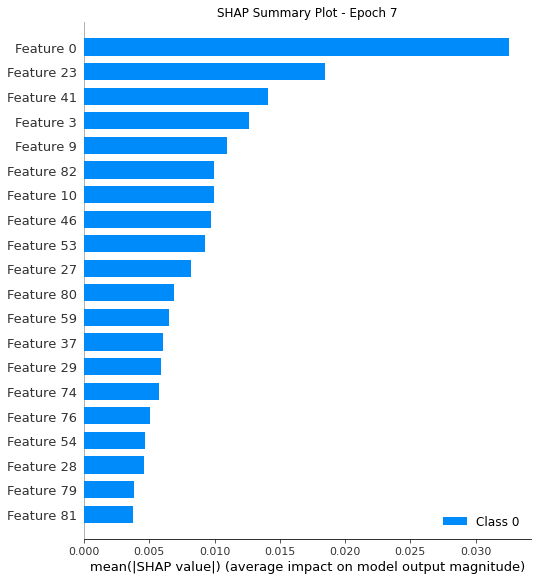

6939/6939 - 17s - loss: 0.0232 - val_loss: 0.0231
Epoch 8/100


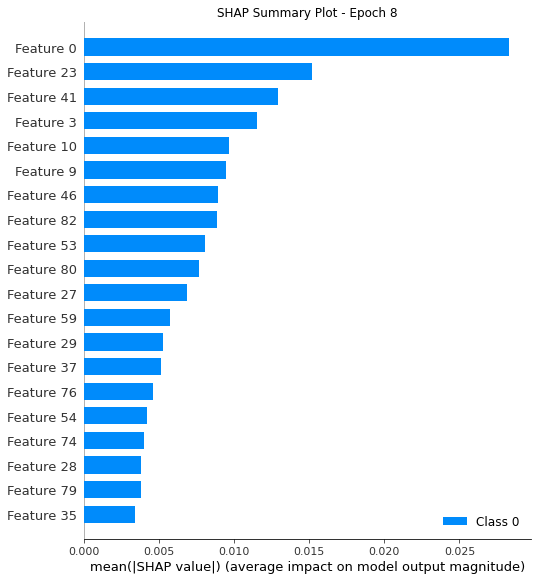

6939/6939 - 17s - loss: 0.0232 - val_loss: 0.0232
Epoch 9/100


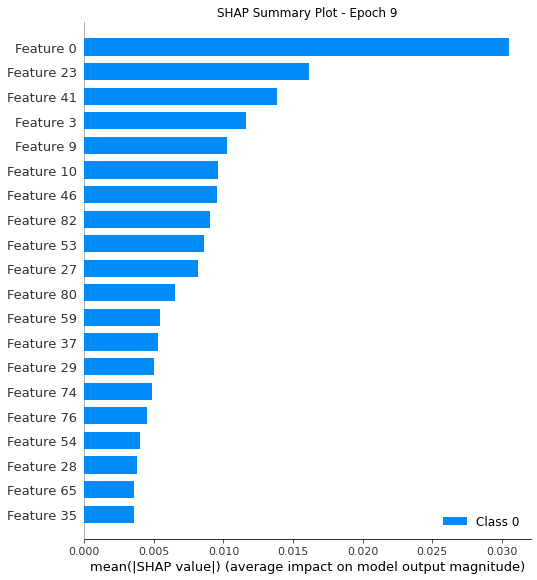

6939/6939 - 18s - loss: 0.0232 - val_loss: 0.0232
Epoch 10/100


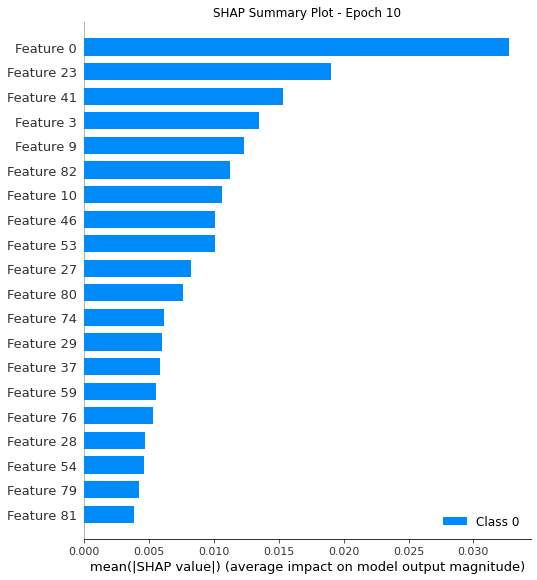

6939/6939 - 17s - loss: 0.0232 - val_loss: 0.0230
Epoch 11/100


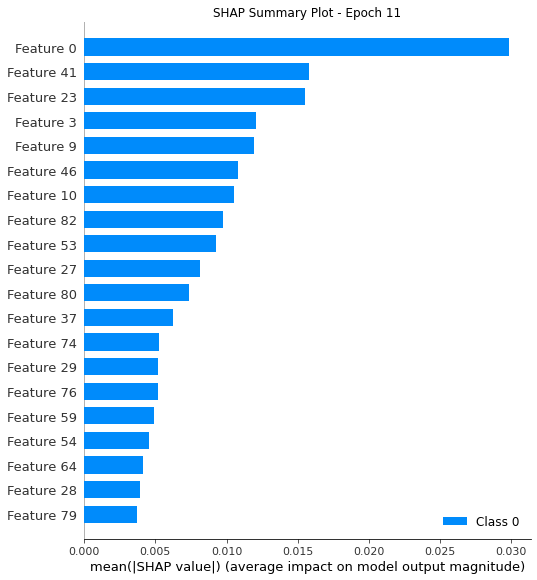

6939/6939 - 17s - loss: 0.0232 - val_loss: 0.0231
Epoch 12/100


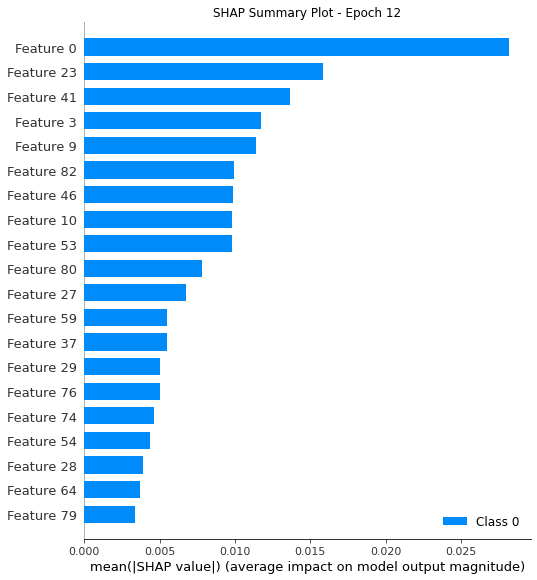

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0231
Epoch 13/100


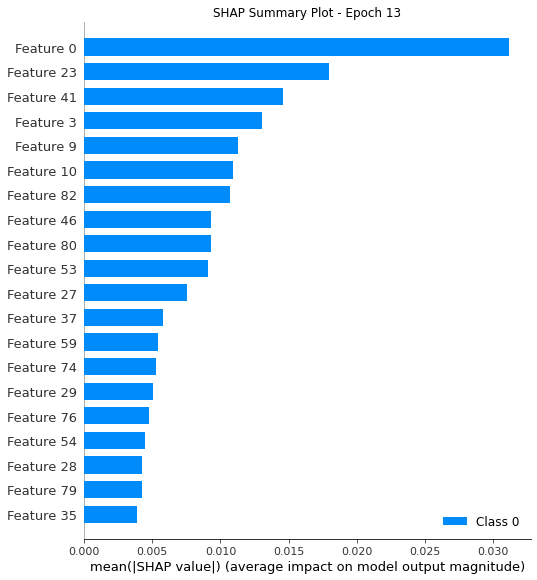

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 14/100


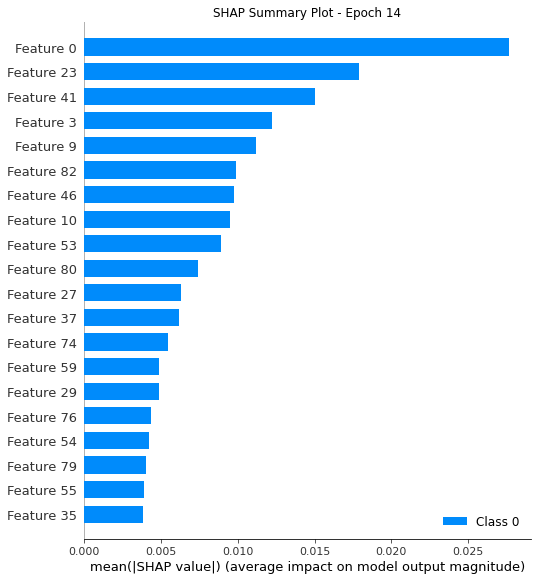

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0231
Epoch 15/100


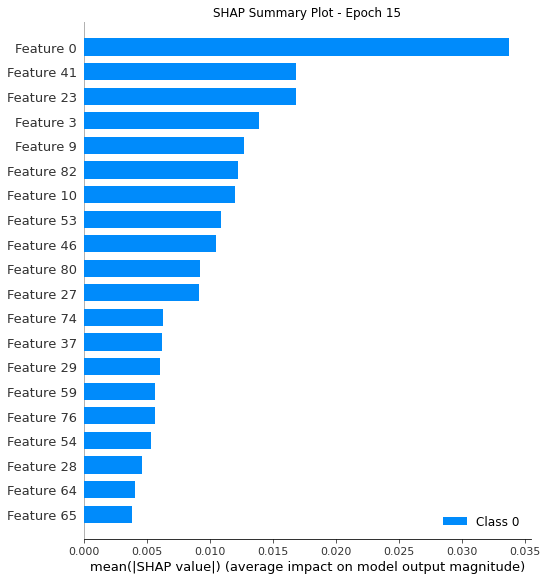

6939/6939 - 16s - loss: 0.0231 - val_loss: 0.0230
Epoch 16/100


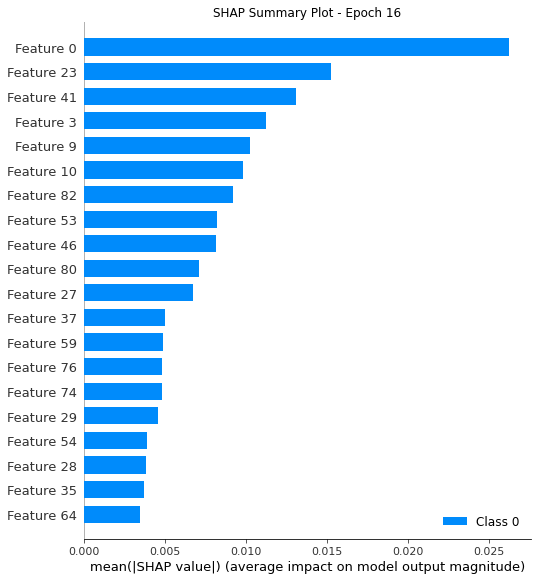

6939/6939 - 23s - loss: 0.0231 - val_loss: 0.0231
Epoch 17/100


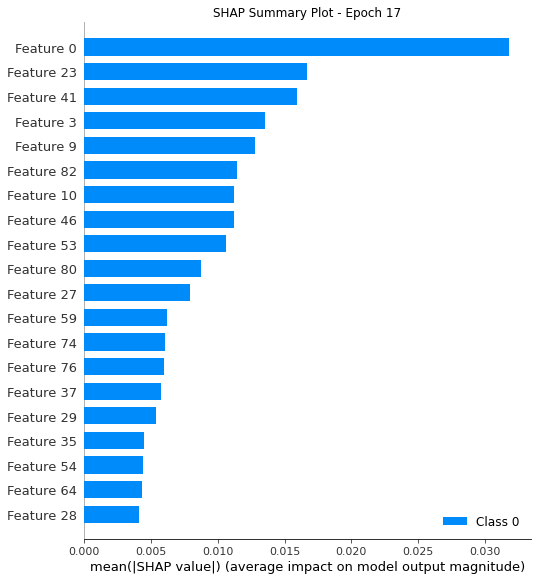

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 18/100


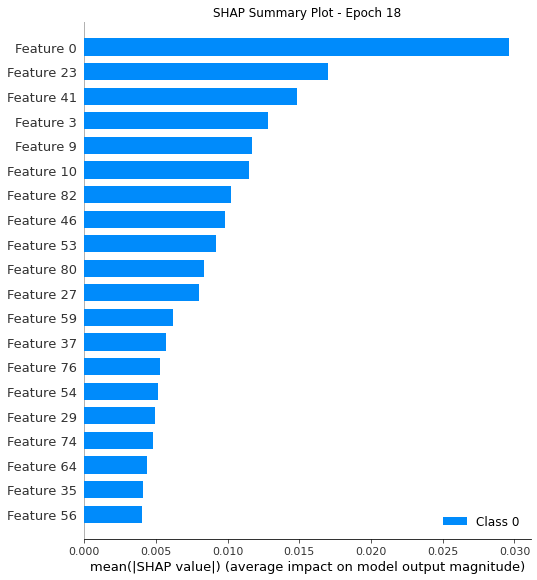

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0231
Epoch 19/100


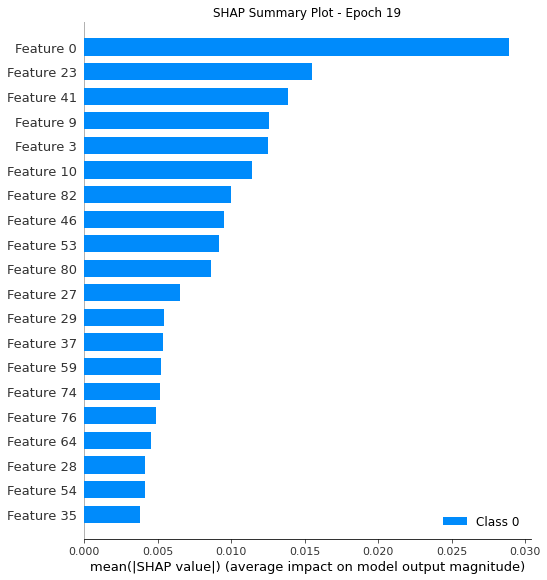

6939/6939 - 16s - loss: 0.0231 - val_loss: 0.0231
Epoch 20/100


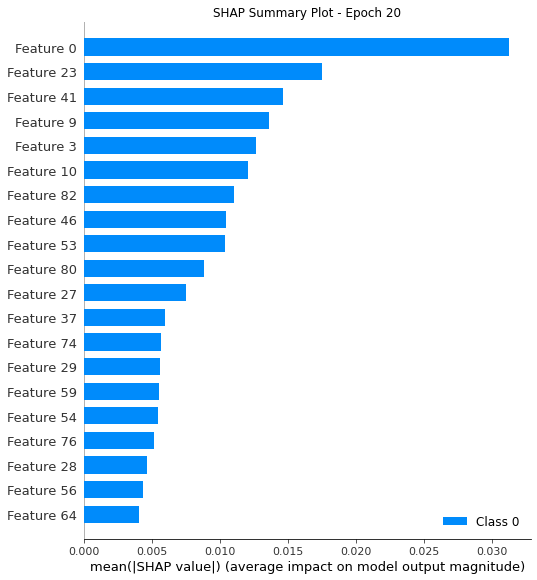

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 21/100


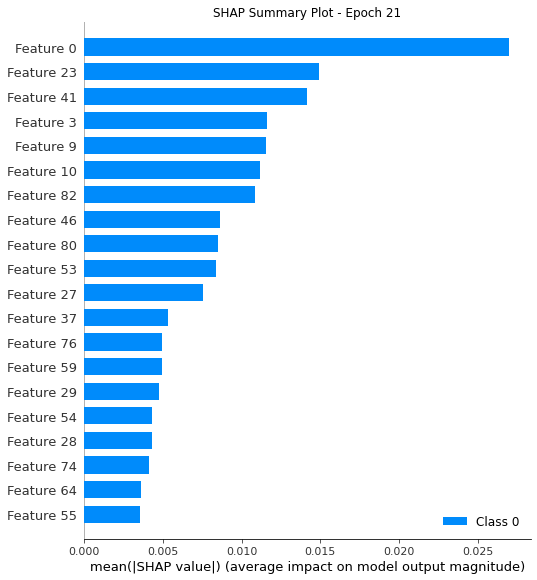

6939/6939 - 16s - loss: 0.0231 - val_loss: 0.0232
Epoch 22/100


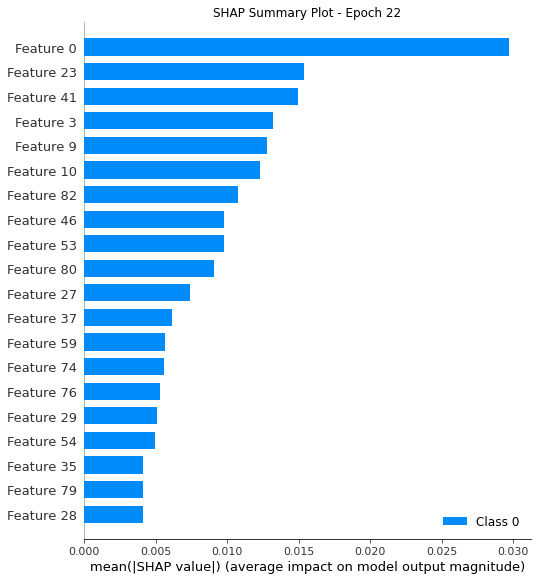

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0229
Epoch 23/100


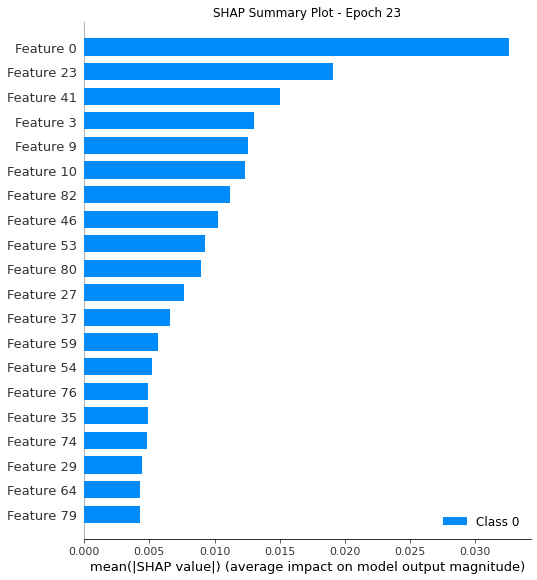

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 24/100


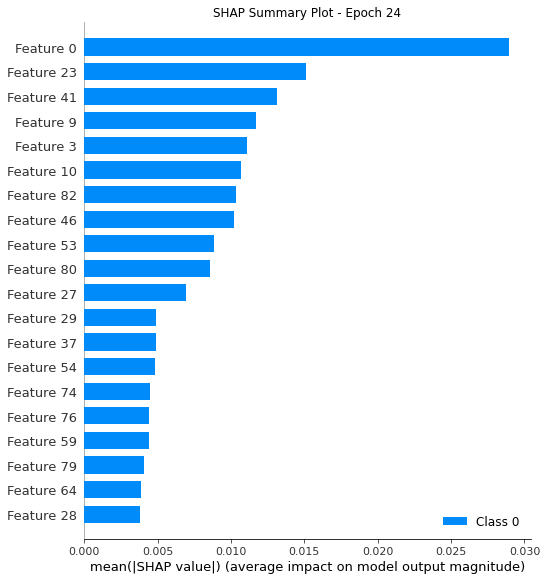

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0231
Epoch 25/100


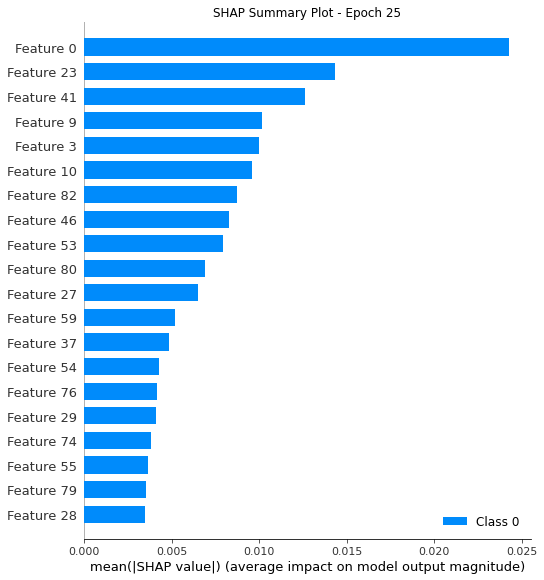

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0232
Epoch 26/100


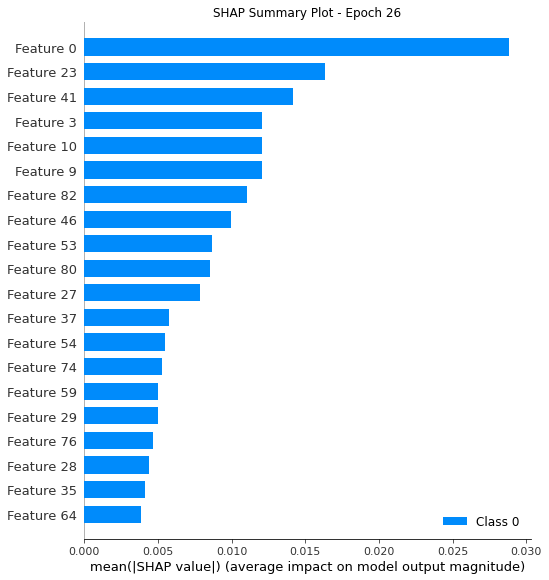

6939/6939 - 16s - loss: 0.0231 - val_loss: 0.0230
Epoch 27/100


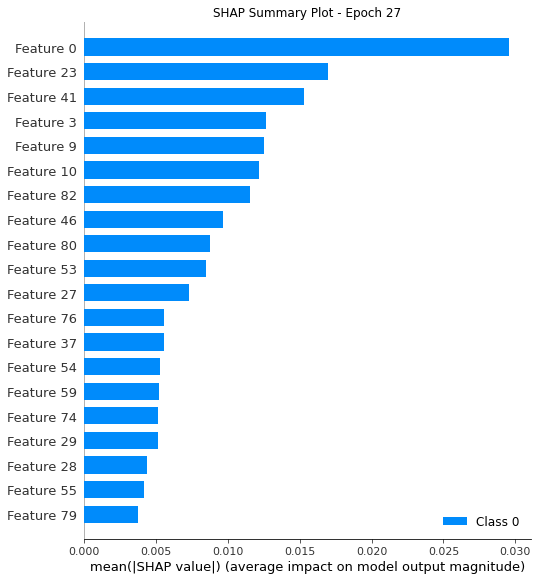

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 28/100


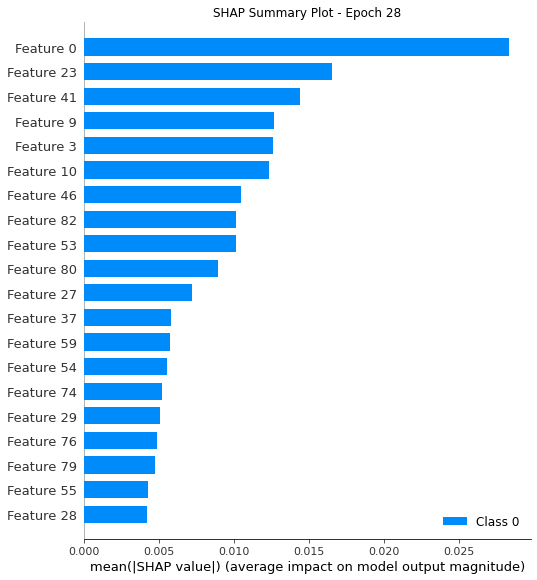

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 29/100


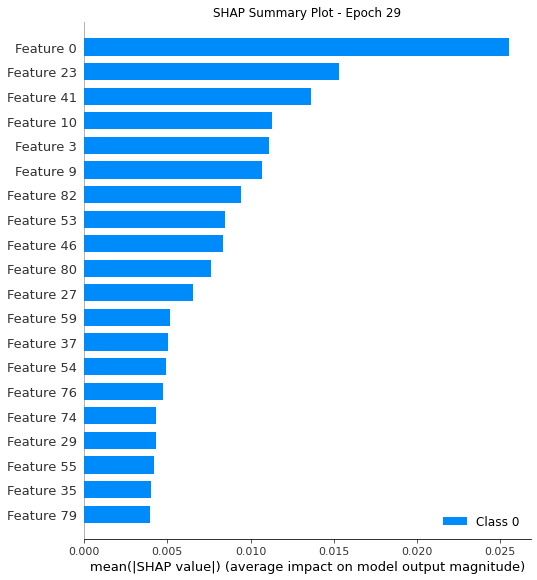

6939/6939 - 16s - loss: 0.0231 - val_loss: 0.0231
Epoch 30/100


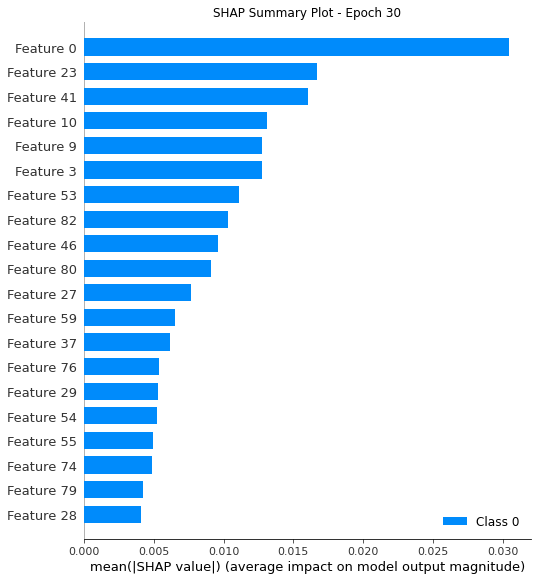

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 31/100


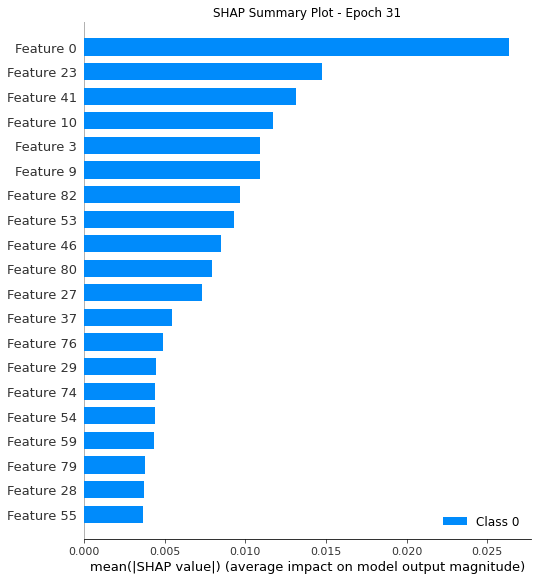

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0232
Epoch 32/100


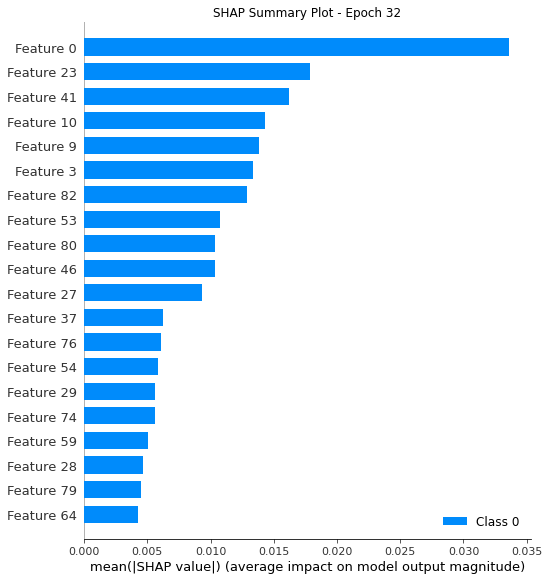

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 33/100


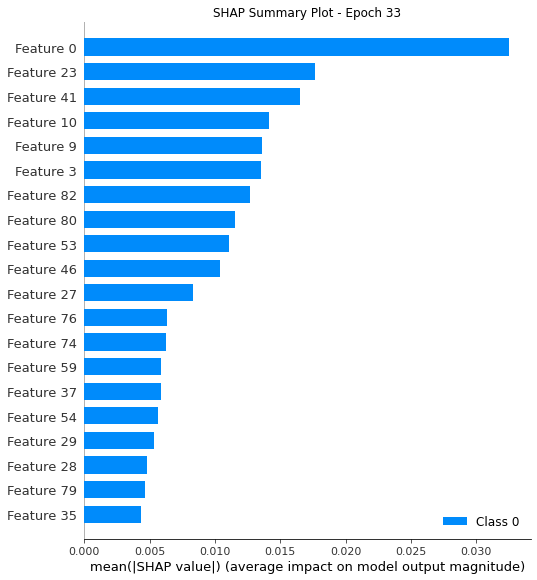

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0229
Epoch 34/100


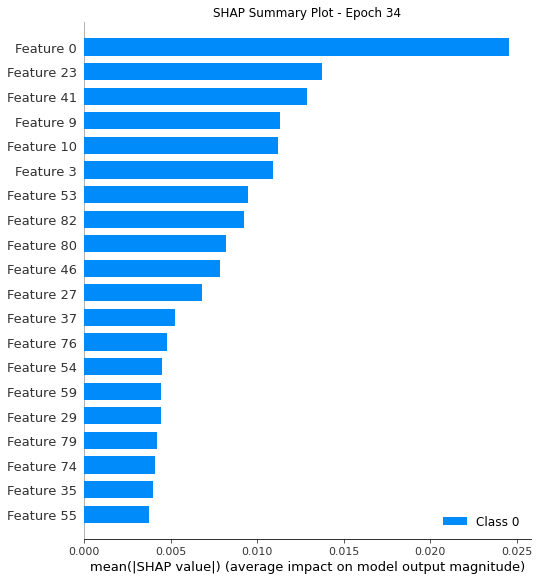

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0231
Epoch 35/100


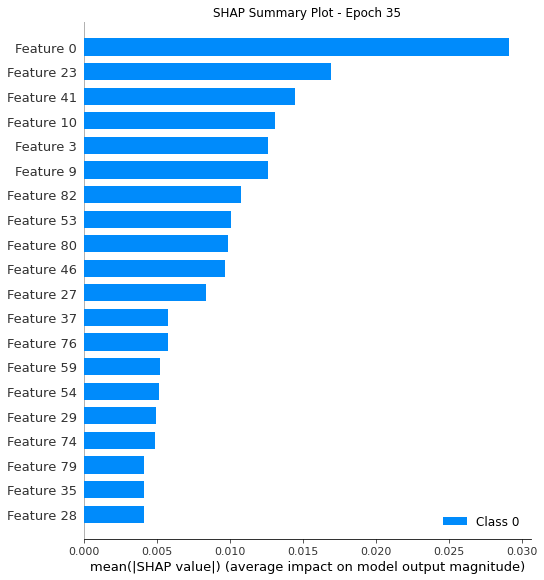

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0230
Epoch 36/100


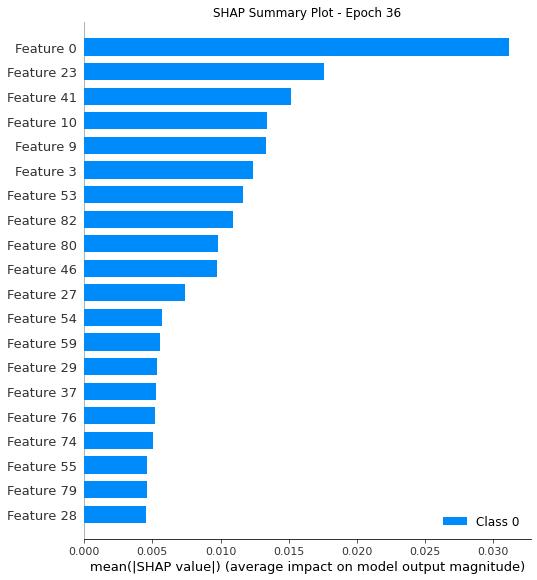

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0229
Epoch 37/100


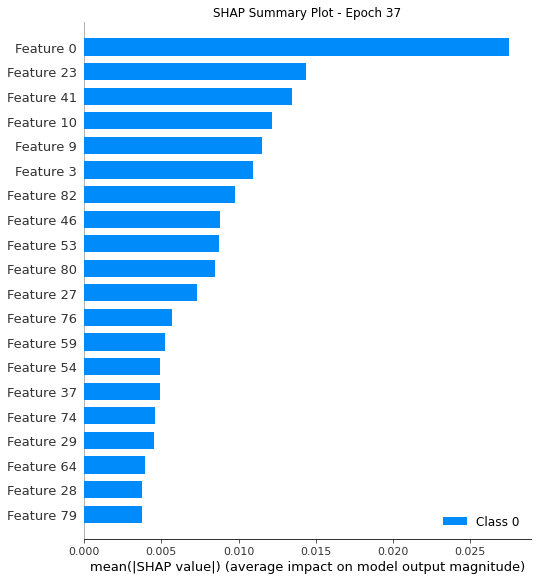

6939/6939 - 17s - loss: 0.0231 - val_loss: 0.0231
Epoch 38/100


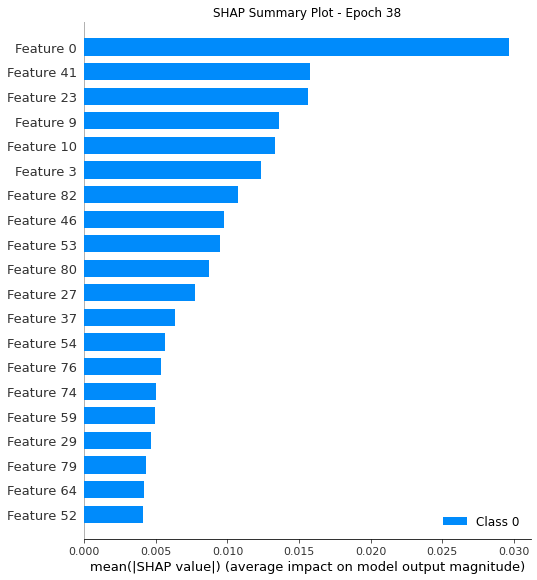

6939/6939 - 18s - loss: 0.0230 - val_loss: 0.0230
Epoch 39/100


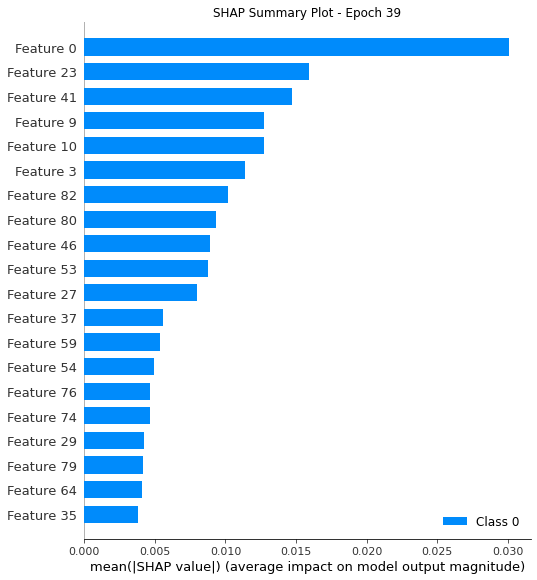

6939/6939 - 19s - loss: 0.0230 - val_loss: 0.0231
Epoch 40/100


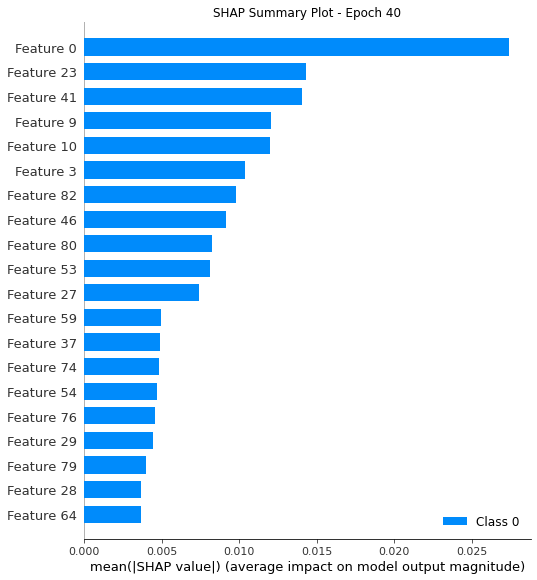

6939/6939 - 20s - loss: 0.0231 - val_loss: 0.0230
Epoch 41/100


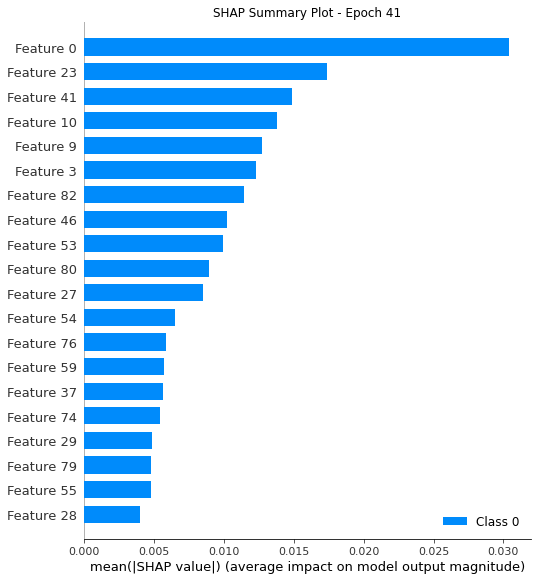

6939/6939 - 19s - loss: 0.0230 - val_loss: 0.0230
Epoch 42/100


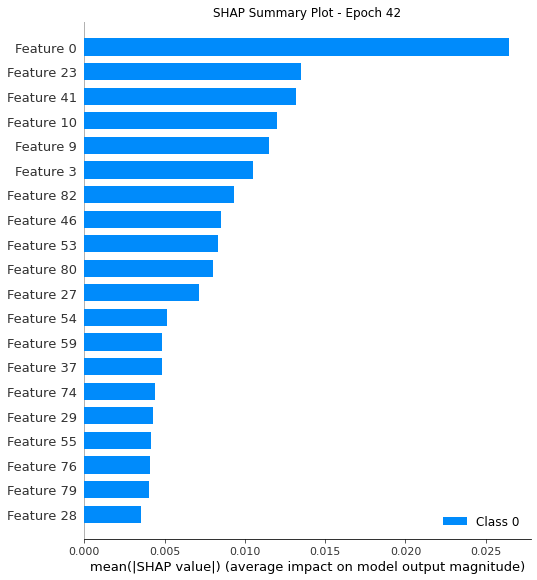

6939/6939 - 19s - loss: 0.0230 - val_loss: 0.0231
Epoch 43/100


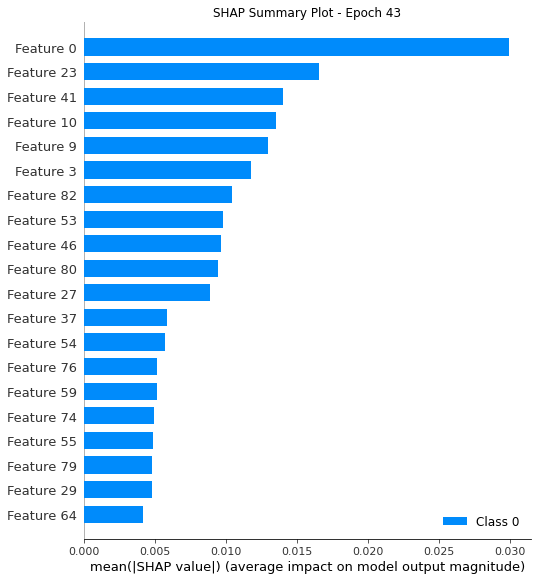

6939/6939 - 18s - loss: 0.0230 - val_loss: 0.0230
Epoch 44/100


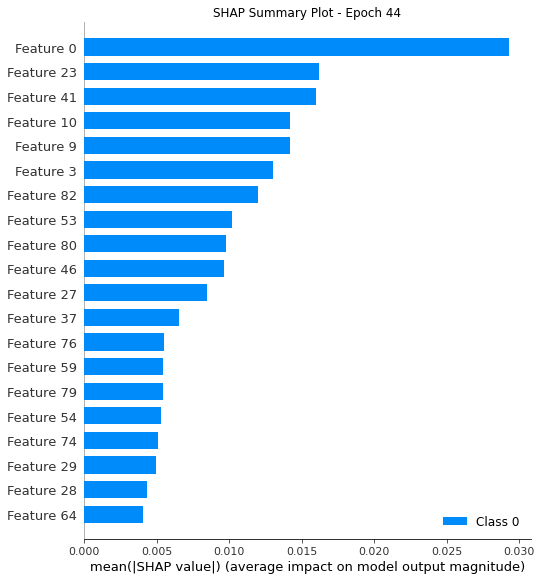

6939/6939 - 19s - loss: 0.0230 - val_loss: 0.0230
Epoch 45/100


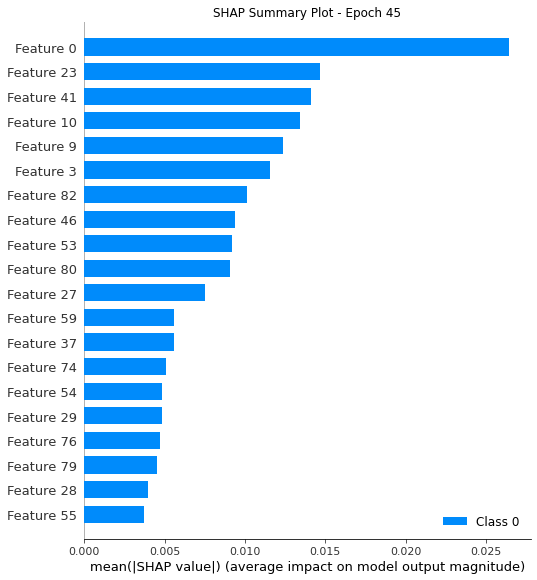

6939/6939 - 19s - loss: 0.0230 - val_loss: 0.0230
Epoch 46/100


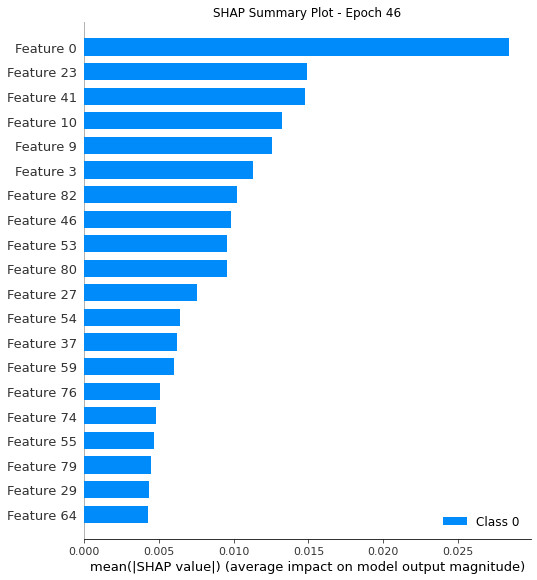

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0231
Epoch 47/100


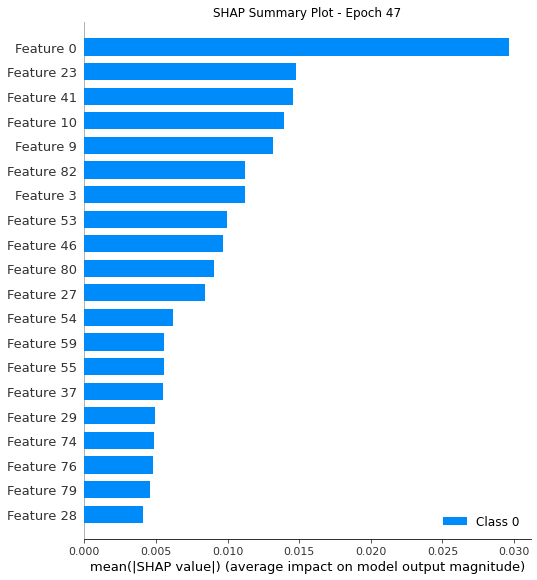

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 48/100


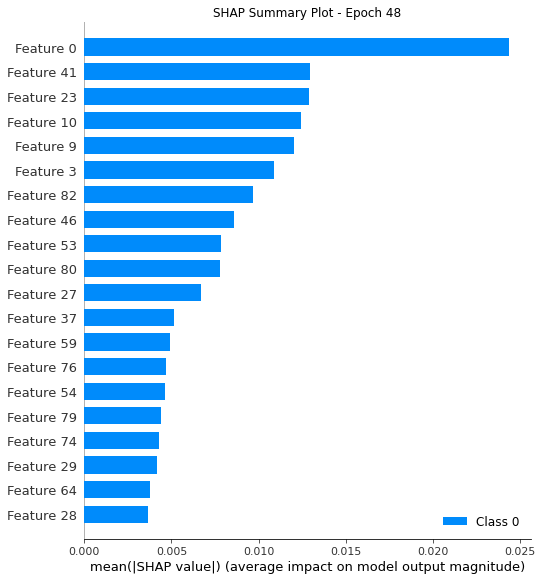

6939/6939 - 18s - loss: 0.0230 - val_loss: 0.0232
Epoch 49/100


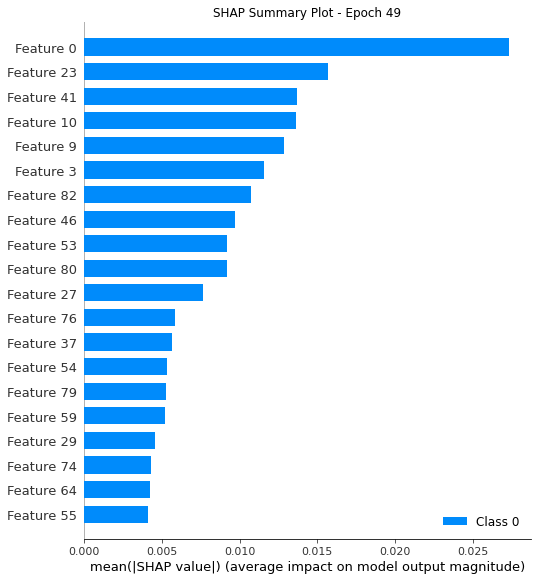

6939/6939 - 19s - loss: 0.0230 - val_loss: 0.0231
Epoch 50/100


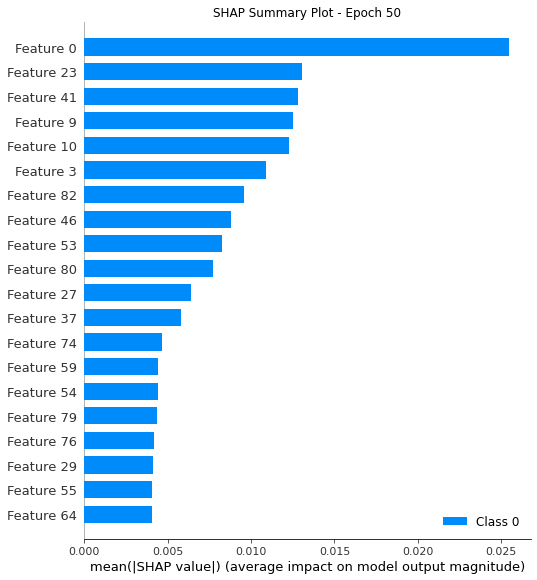

6939/6939 - 18s - loss: 0.0230 - val_loss: 0.0232
Epoch 51/100


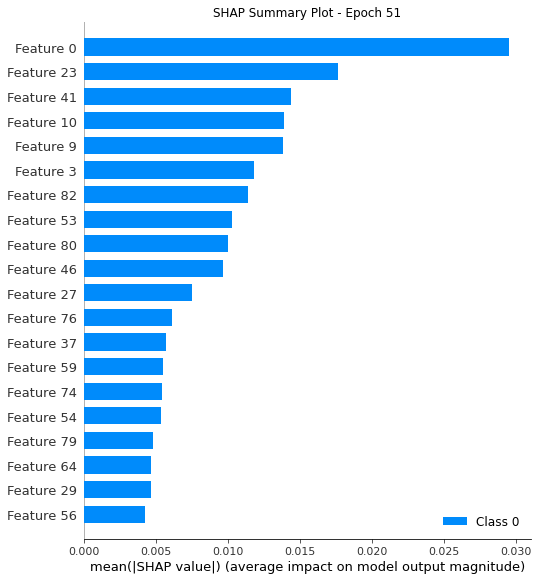

6939/6939 - 19s - loss: 0.0230 - val_loss: 0.0230
Epoch 52/100


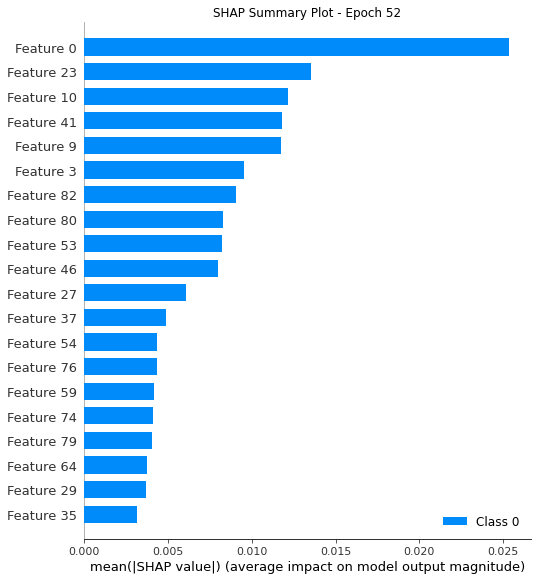

6939/6939 - 18s - loss: 0.0230 - val_loss: 0.0231
Epoch 53/100


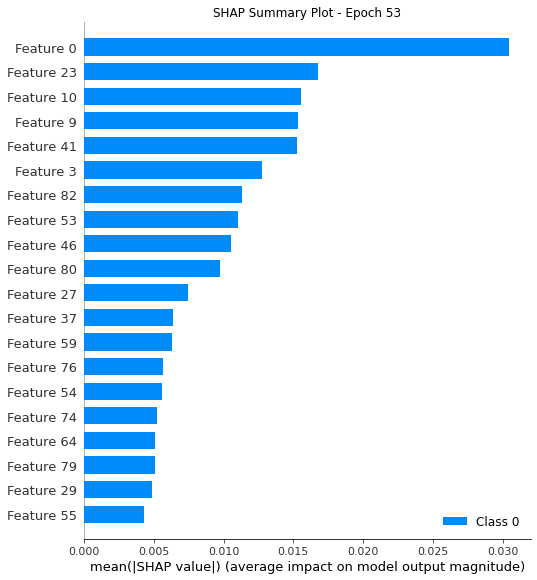

6939/6939 - 18s - loss: 0.0230 - val_loss: 0.0230
Epoch 54/100


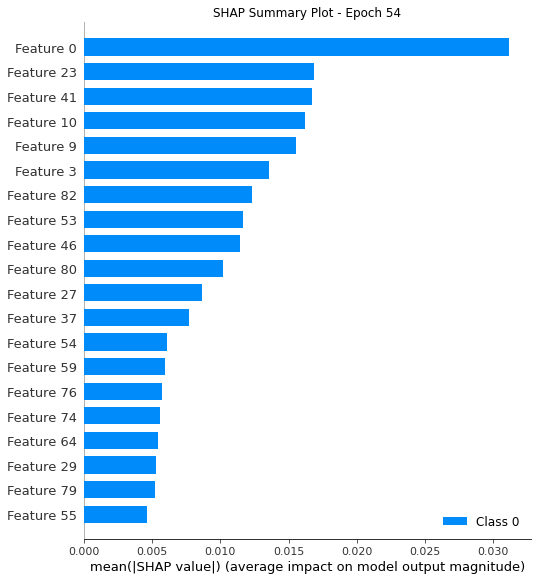

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0229
Epoch 55/100


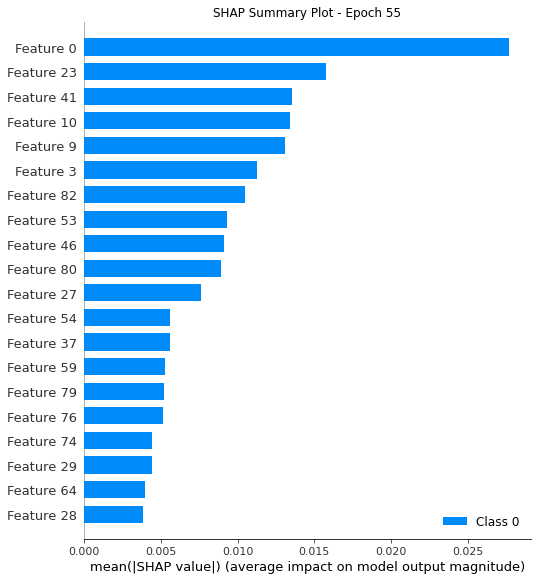

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 56/100


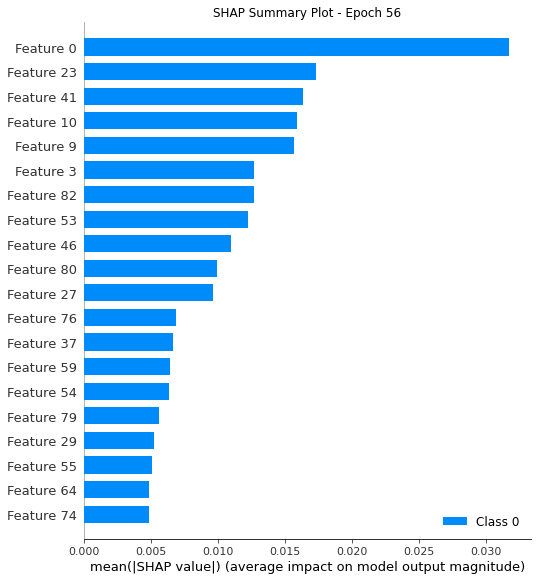

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 57/100


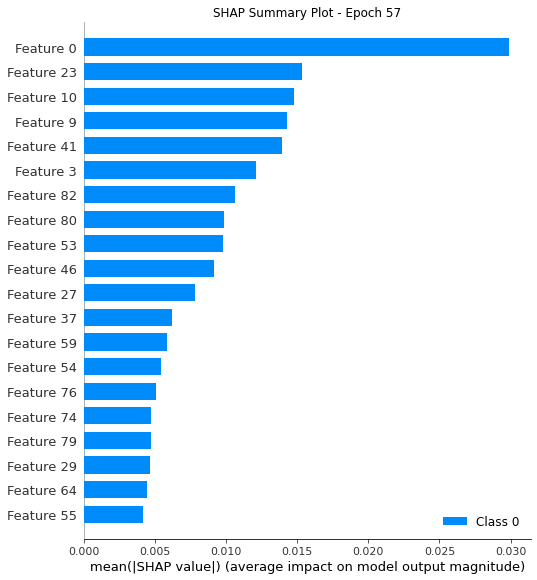

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 58/100


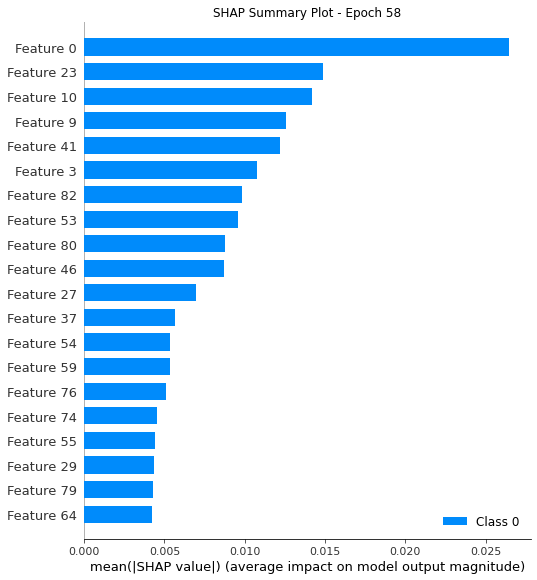

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0231
Epoch 59/100


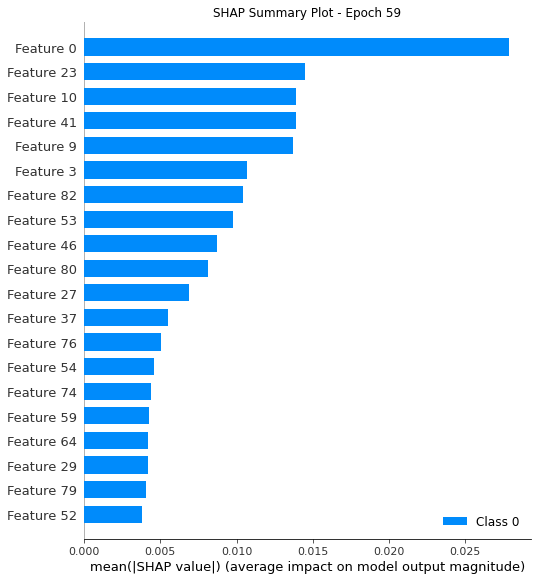

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0231
Epoch 60/100


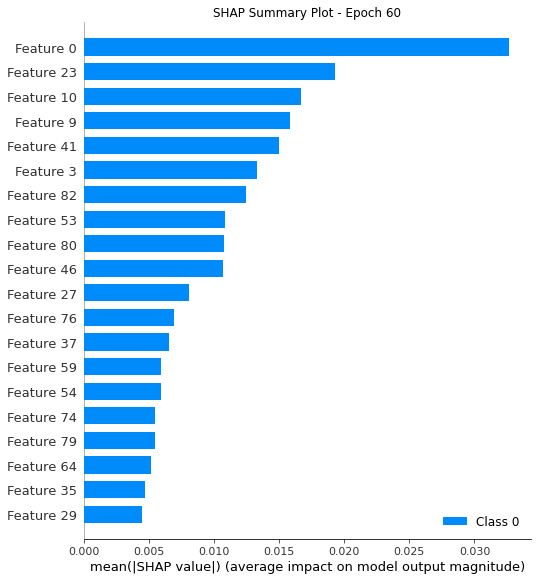

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0229
Epoch 61/100


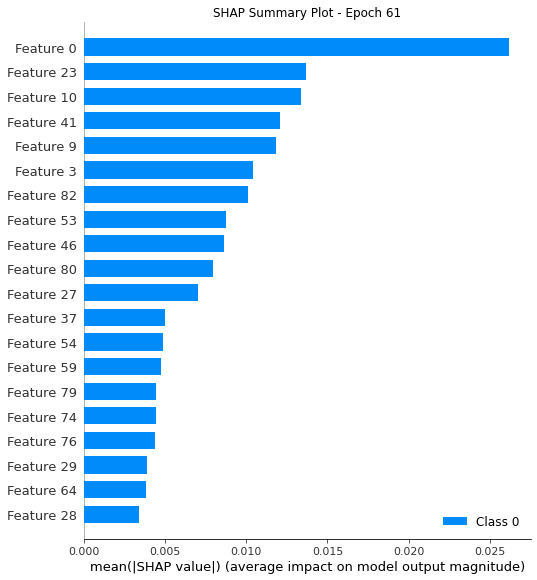

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0234
Epoch 62/100


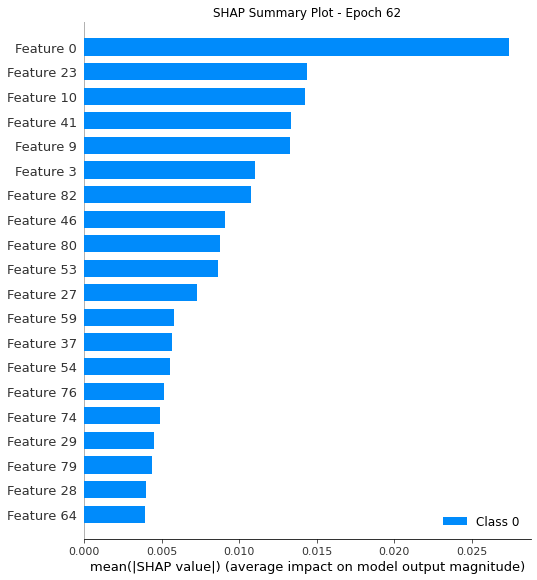

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0231
Epoch 63/100


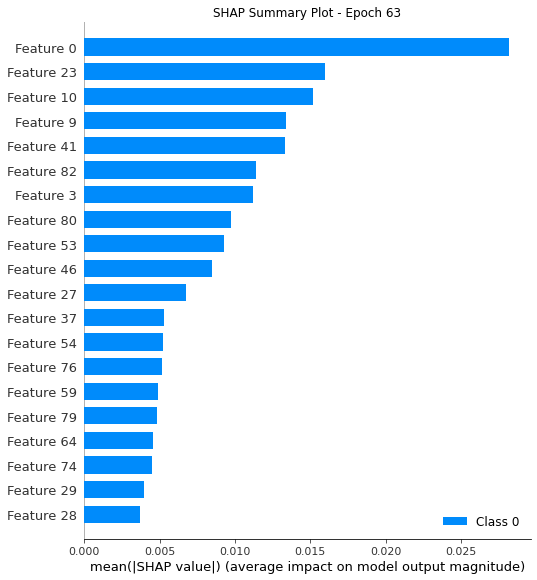

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 64/100


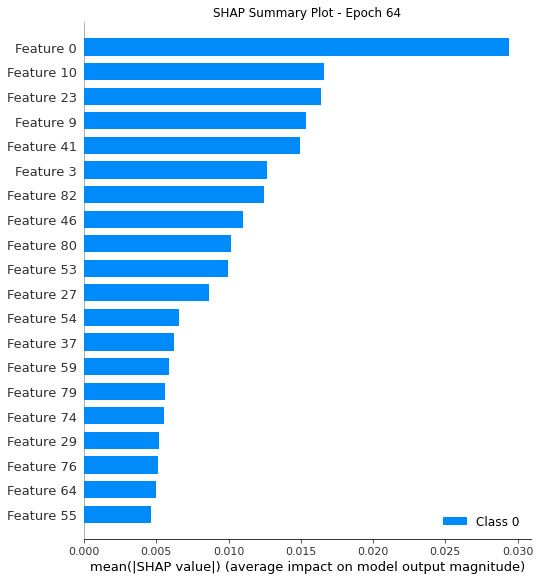

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 65/100


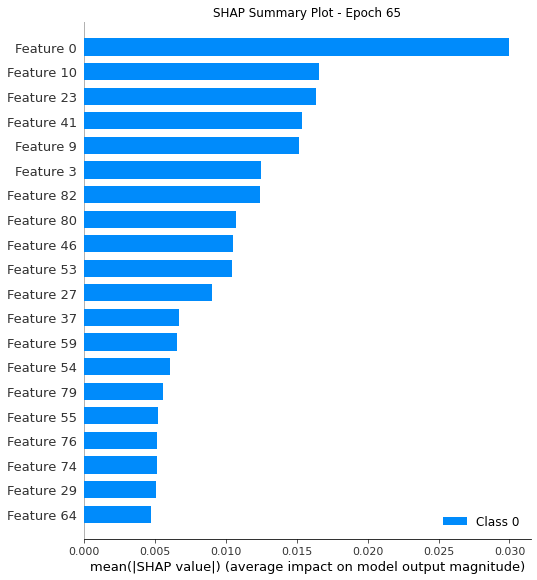

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 66/100


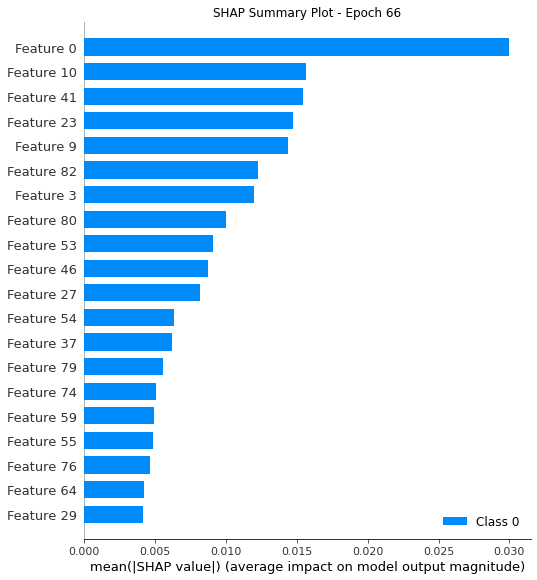

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0231
Epoch 67/100


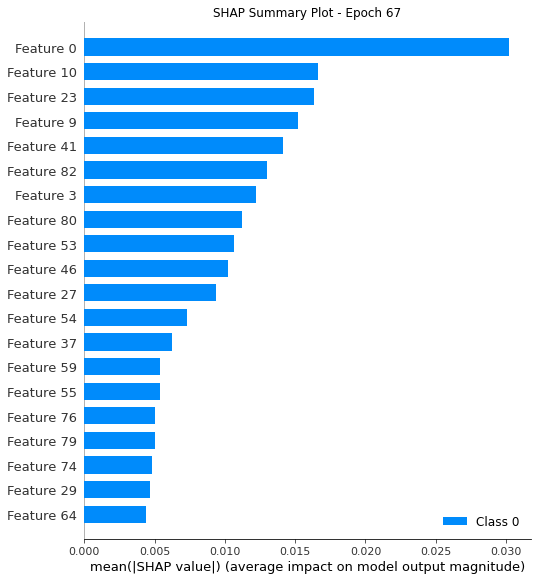

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 68/100


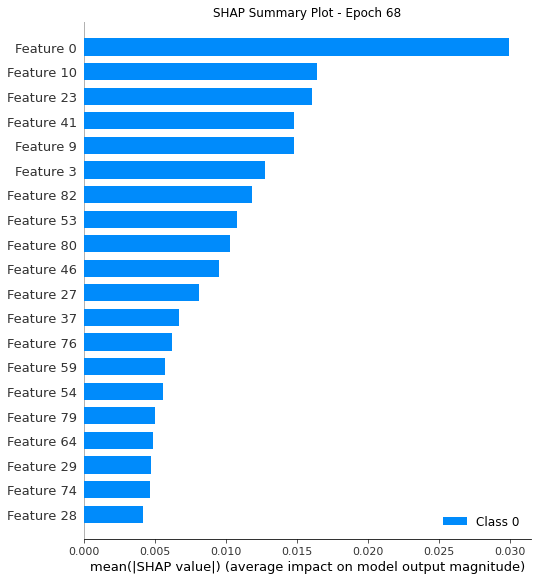

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0229
Epoch 69/100


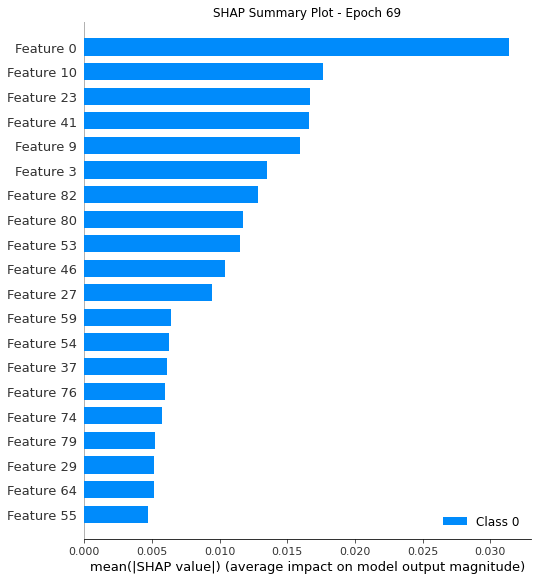

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0229
Epoch 70/100


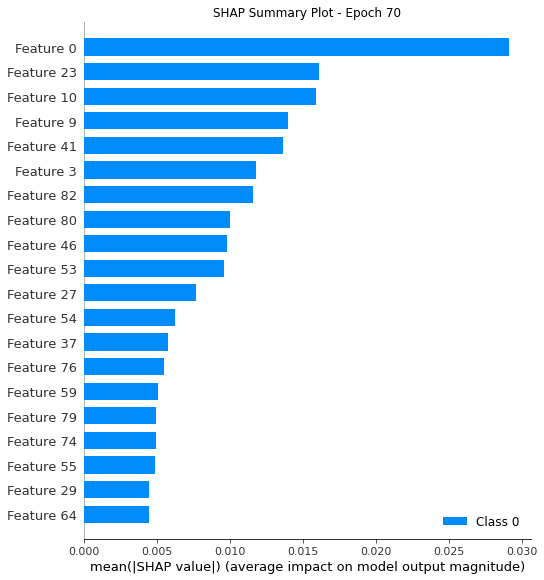

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0230
Epoch 71/100


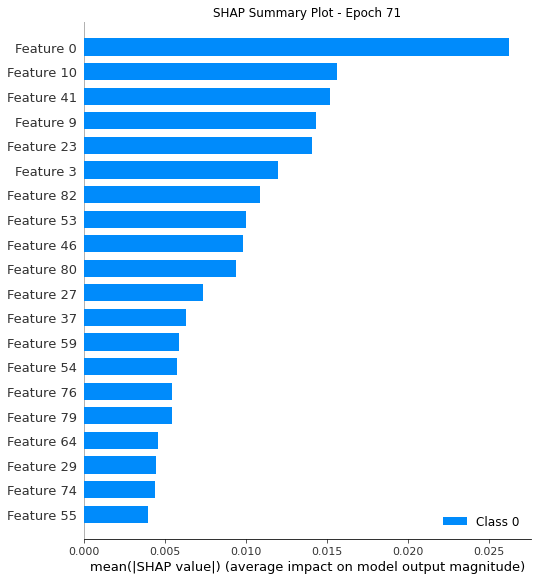

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0231
Epoch 72/100


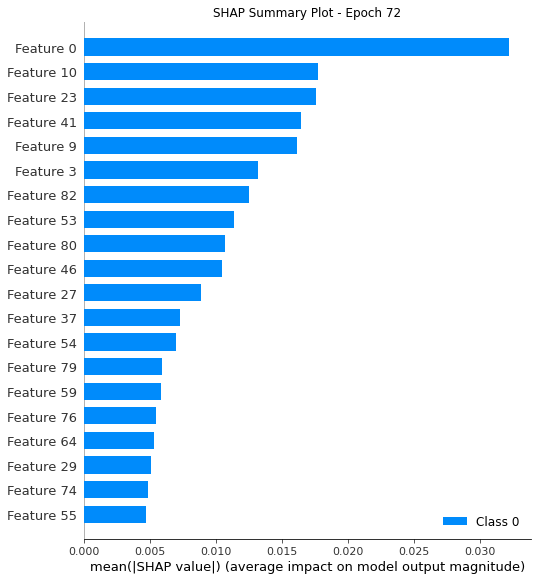

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0229
Epoch 73/100


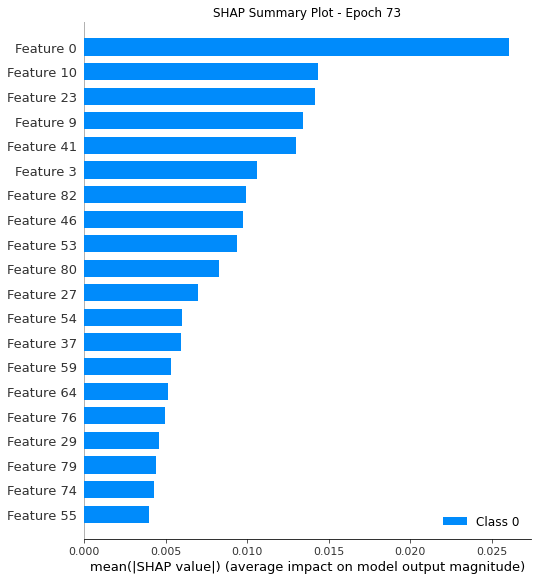

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0231
Epoch 74/100


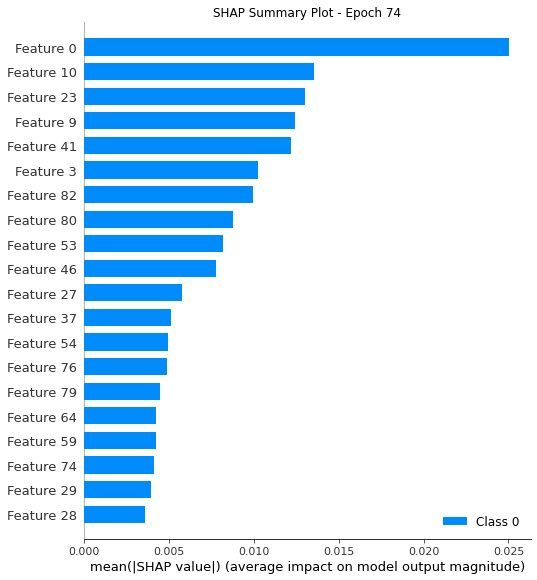

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0231
Epoch 75/100


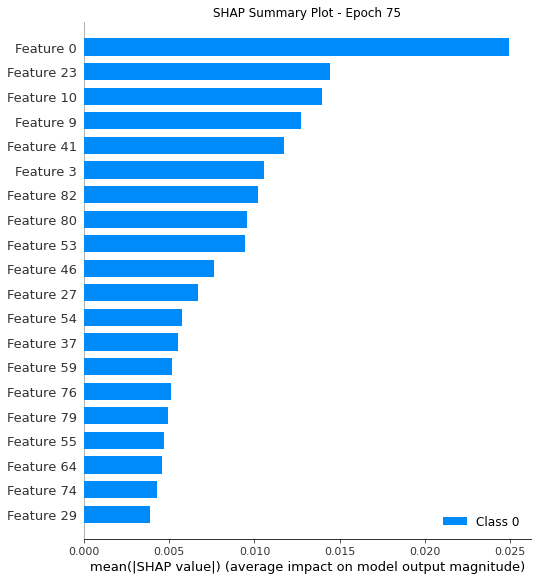

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0231
Epoch 76/100


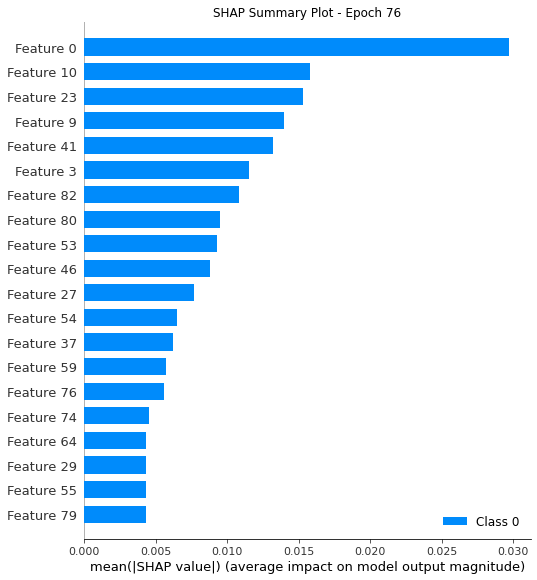

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 77/100


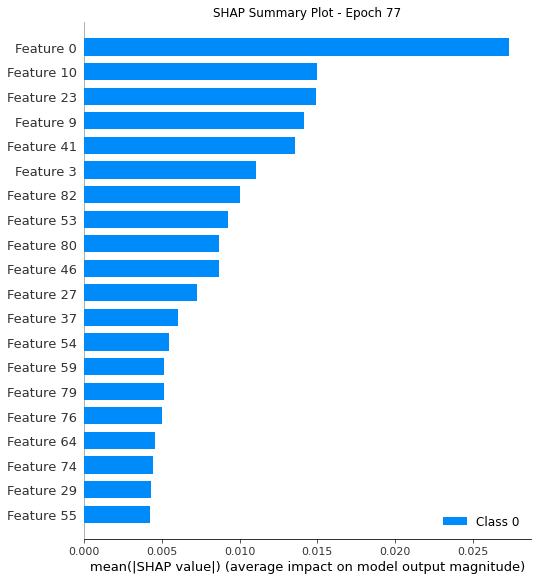

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0231
Epoch 78/100


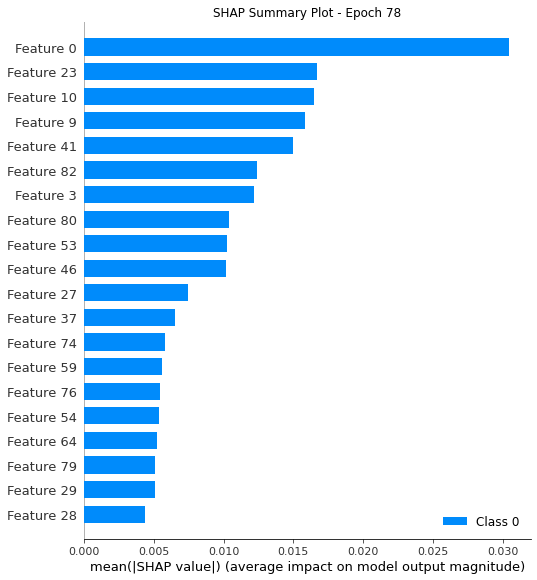

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0230
Epoch 79/100


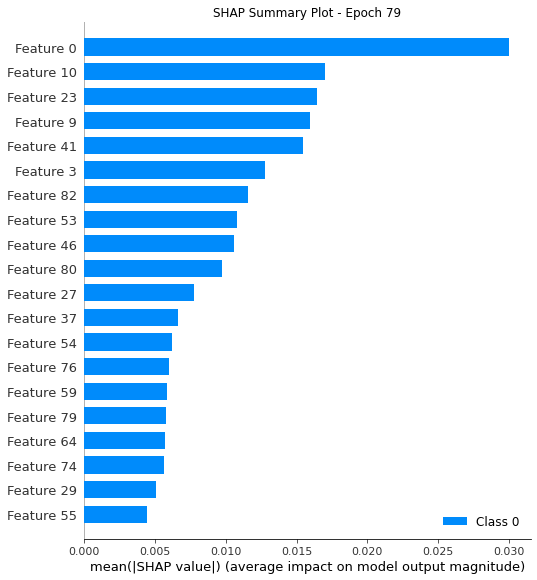

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0229
Epoch 80/100


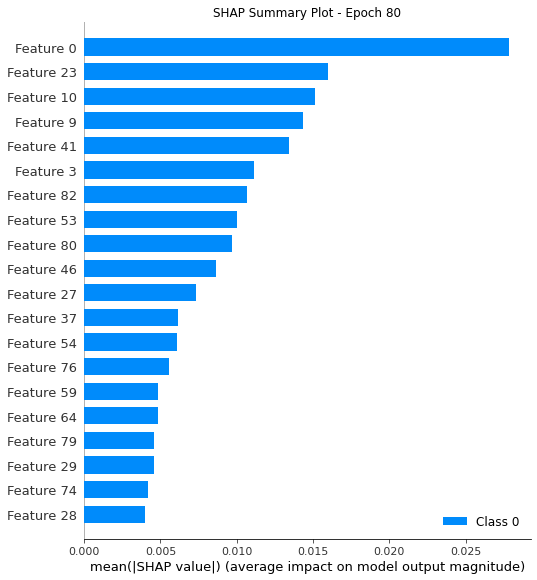

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 81/100


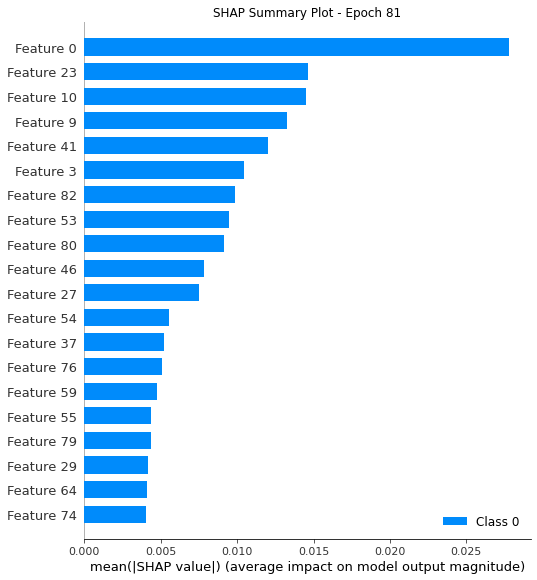

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0231
Epoch 82/100


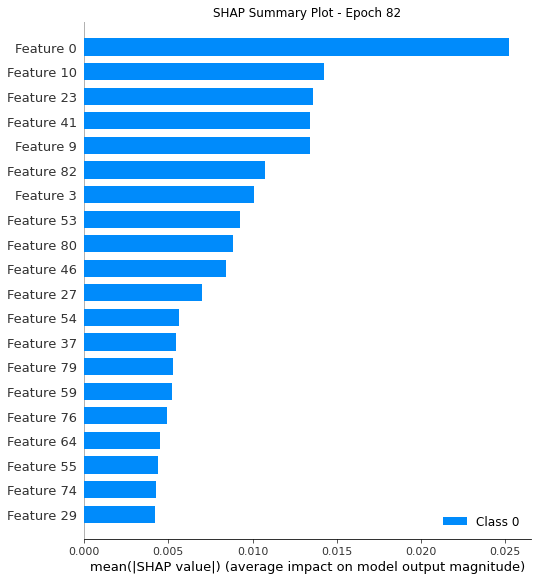

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0231
Epoch 83/100


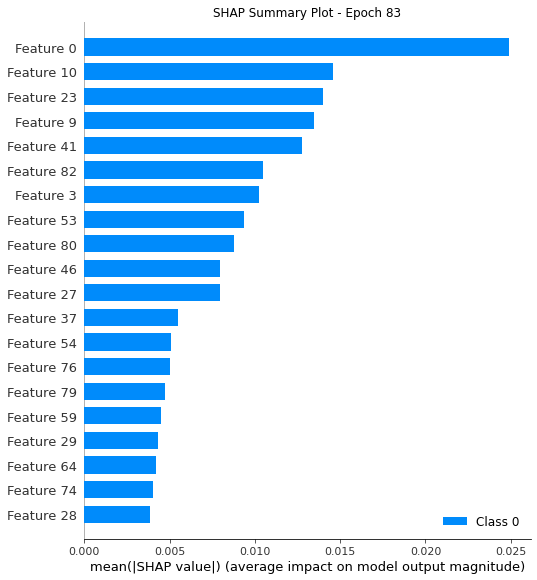

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0232
Epoch 84/100


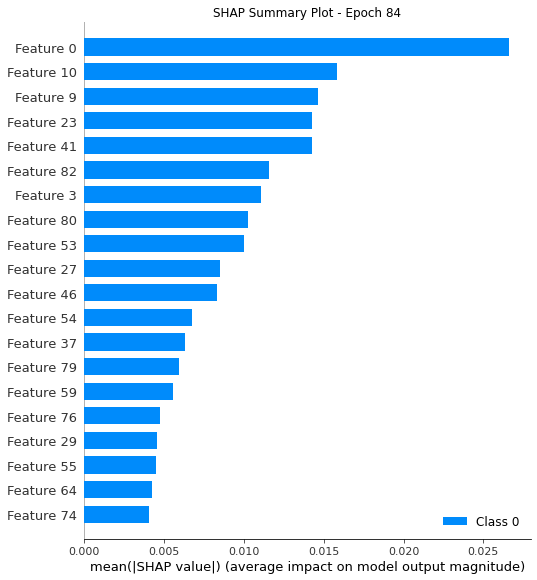

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0231
Epoch 85/100


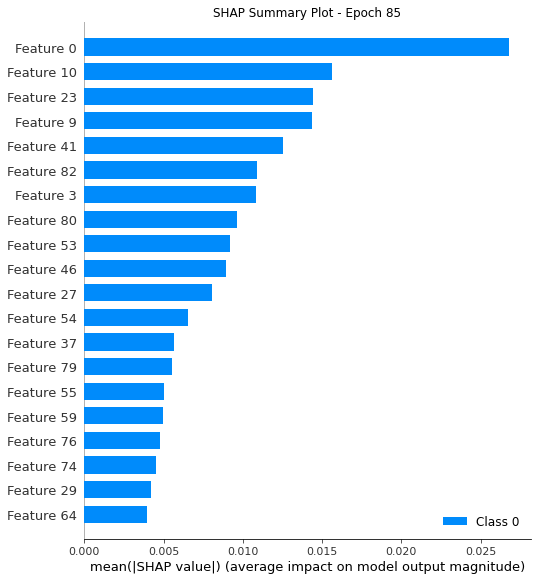

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0230
Epoch 86/100


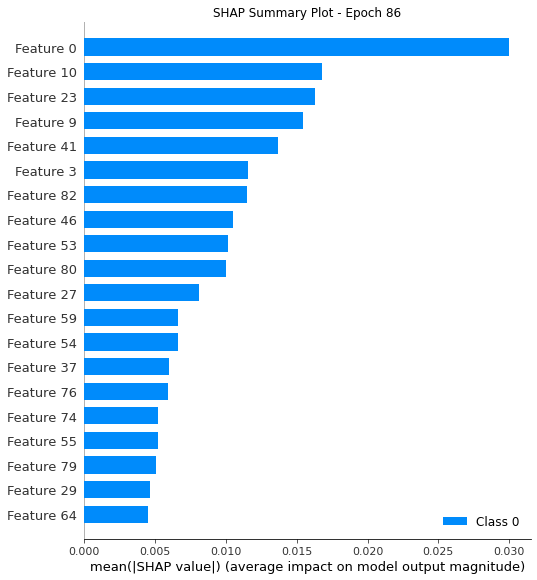

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0230
Epoch 87/100


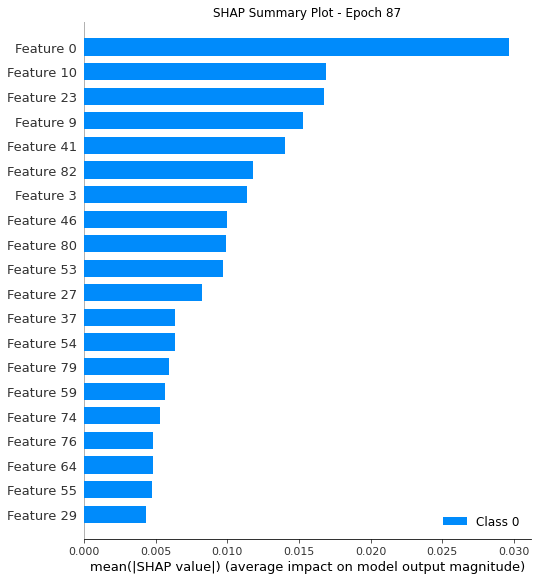

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 88/100


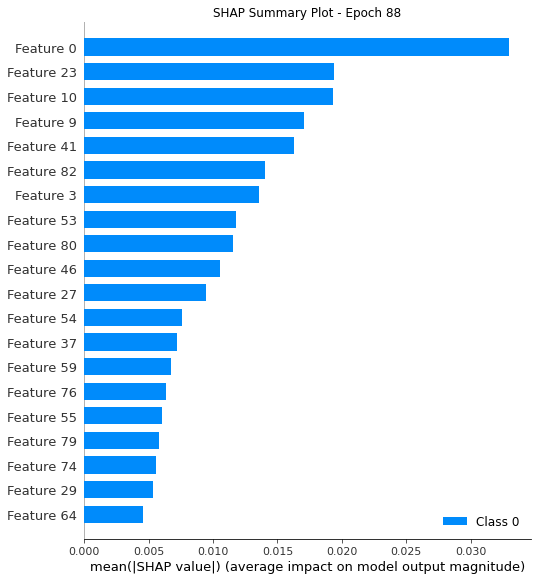

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0229
Epoch 89/100


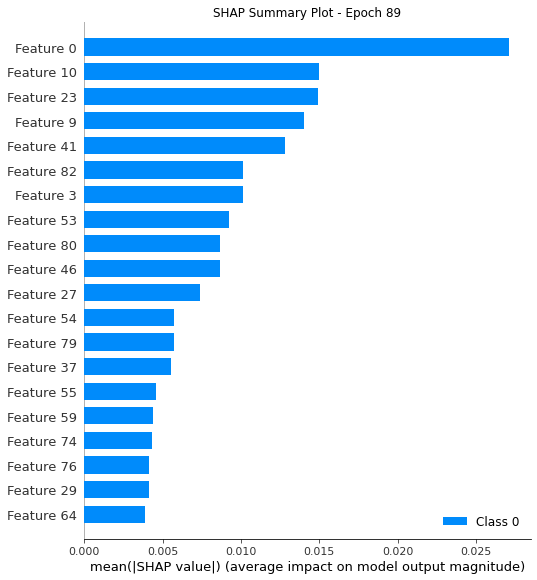

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 90/100


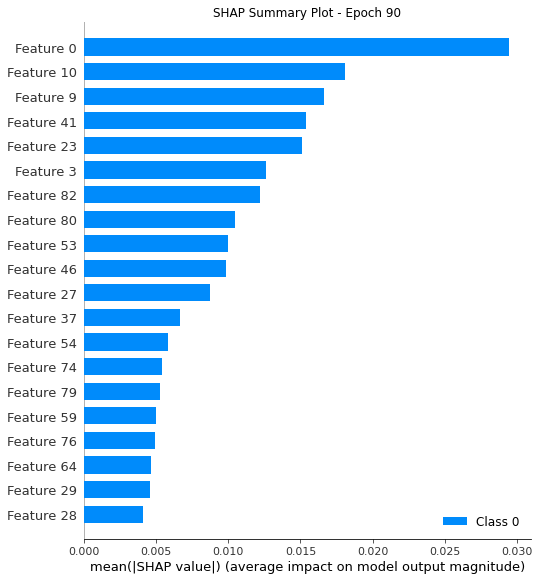

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 91/100


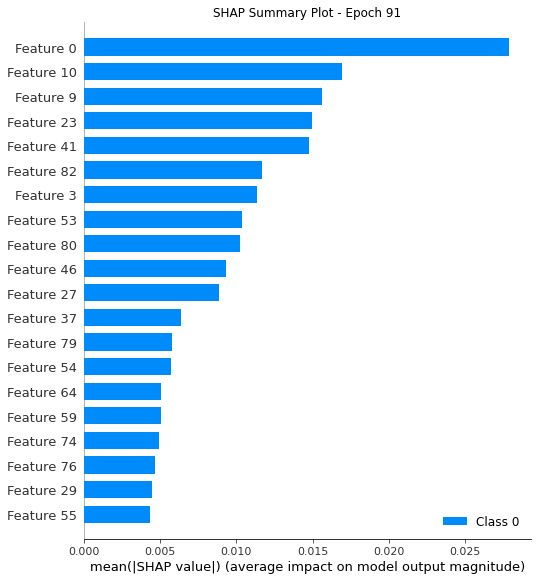

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 92/100


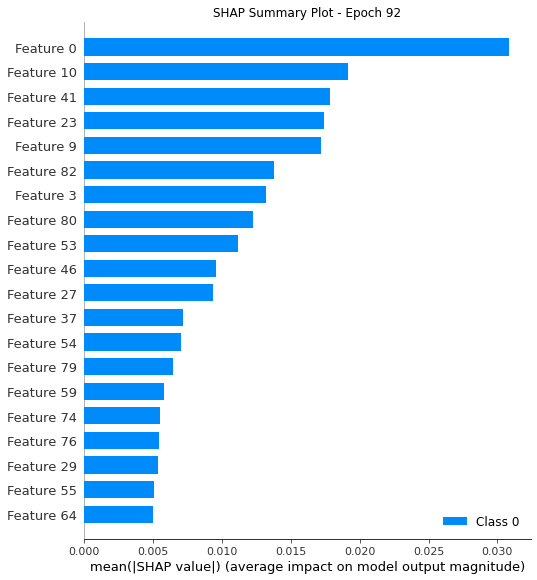

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0229
Epoch 93/100


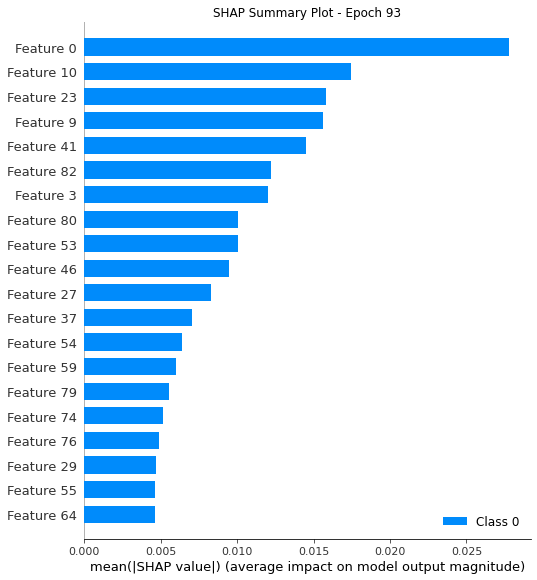

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0230
Epoch 94/100


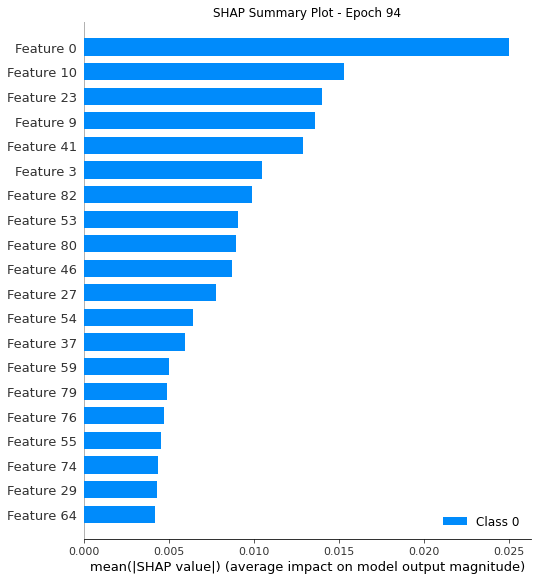

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0232
Epoch 95/100


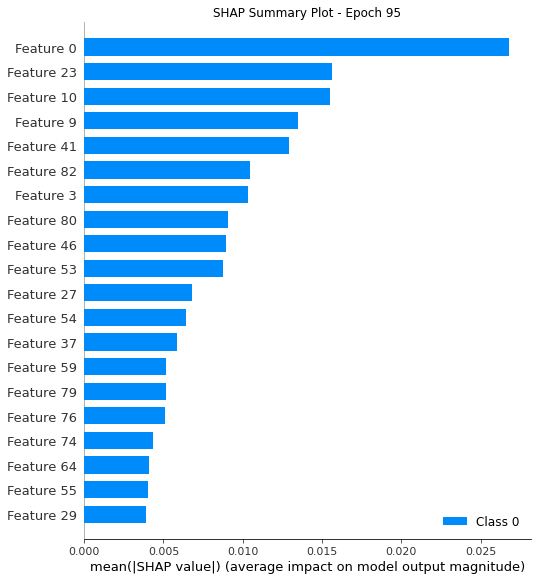

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0232
Epoch 96/100


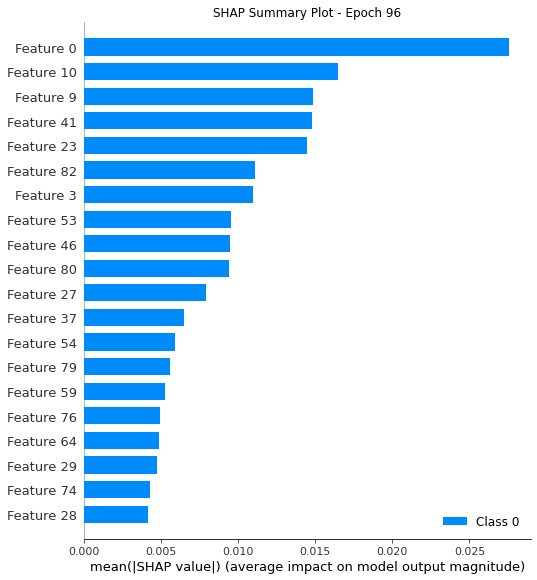

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0230
Epoch 97/100


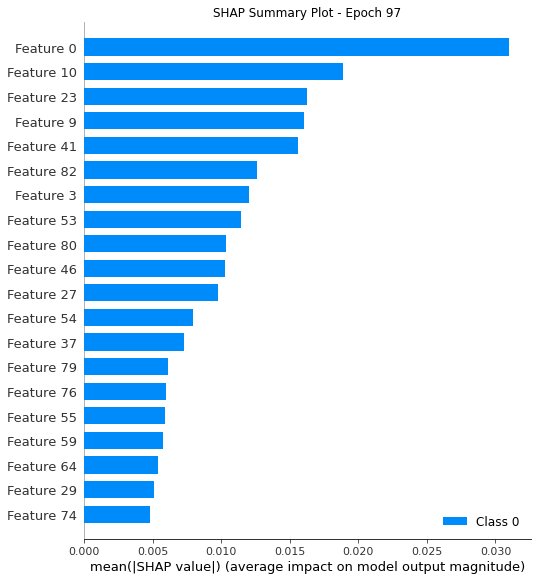

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0230
Epoch 98/100


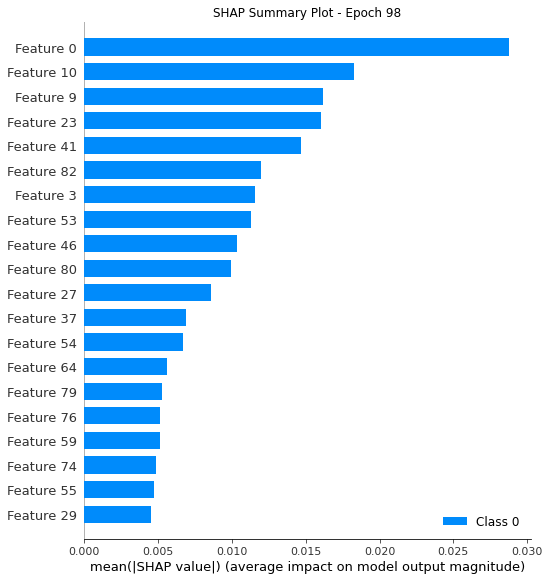

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0231
Epoch 99/100


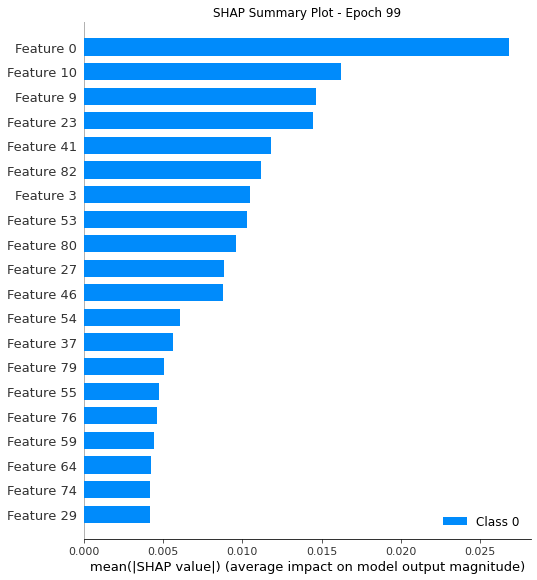

6939/6939 - 17s - loss: 0.0230 - val_loss: 0.0232
Epoch 100/100


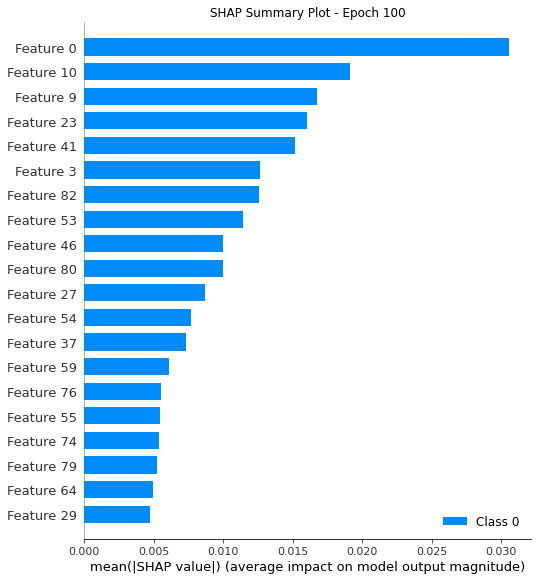

6939/6939 - 16s - loss: 0.0230 - val_loss: 0.0229


In [44]:
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback  # Import the Callback class

def run_pipeline(
    data,
    onehot_cols,
    ordinal_cols,
    batch_size,
    validate=True,
):
    X = data.drop(columns=["fraction_recovered"])
    y = data["fraction_recovered"]
    X_train, X_valid, y_train, y_valid = (
        train_test_split(X, y, test_size=0.2, random_state=0)
        if validate
        else (X, None, y, None)
    )

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    X_train = transformer.fit_transform(X_train)
    X_valid = transformer.transform(X_valid) if validate else None

    input_nodes = X_train.shape[1]
    output_nodes = 1

    model = Sequential()
    model.add(Input((input_nodes,)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3, seed=0))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3, seed=1))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3, seed=2))
    model.add(Dense(output_nodes))
    model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

    # Placeholder to store SHAP values at each interval
    shap_values_history = []

    class SHAPCallback(Callback):  # Correctly define the Callback class
        def __init__(self, model, X_valid, interval=1):
            super().__init__()  # Initialize the base class
            self.model = model
            self.X_valid = X_valid
            self.interval = interval

        def on_epoch_end(self, epoch, logs=None):
            if epoch % self.interval == 0:
                # Use DeepExplainer for neural networks
                explainer = shap.DeepExplainer(self.model, self.X_valid[:100])  # Use a sample for performance
                shap_values = explainer.shap_values(self.X_valid[:100])
                shap_values_history.append((epoch, shap_values))
                shap.summary_plot(shap_values, self.X_valid[:100], show=False)
                plt.title(f'SHAP Summary Plot - Epoch {epoch+1}')
                plt.show()

    # Train the model with SHAP callback
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=100,
        validation_data=(X_valid, y_valid) if validate else None,
        verbose=2,
        callbacks=[SHAPCallback(model, X_valid)]
    )

    return history.history, model, transformer, shap_values_history

# Example usage:
# Replace `loans_1`, `onehot_cols`, and `ordinal_cols` with your actual data and columns
print("Model:")
history_1, model, transformer, shap_values_history = run_pipeline(
    loans_1,
    onehot_cols,
    ordinal_cols,
    batch_size=128,
)

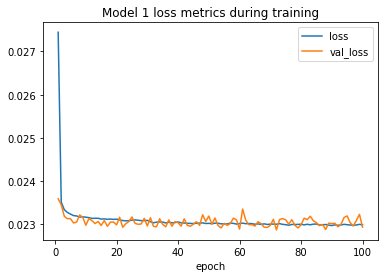

In [46]:
sns.lineplot(x=range(1, 101), y=history_1["loss"], label="loss")
sns.lineplot(x=range(1, 101), y=history_1["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.title("Model 1 loss metrics during training")
plt.show()

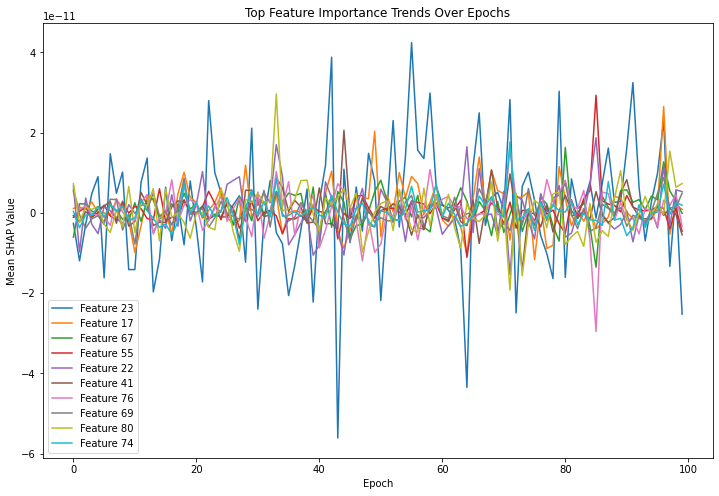

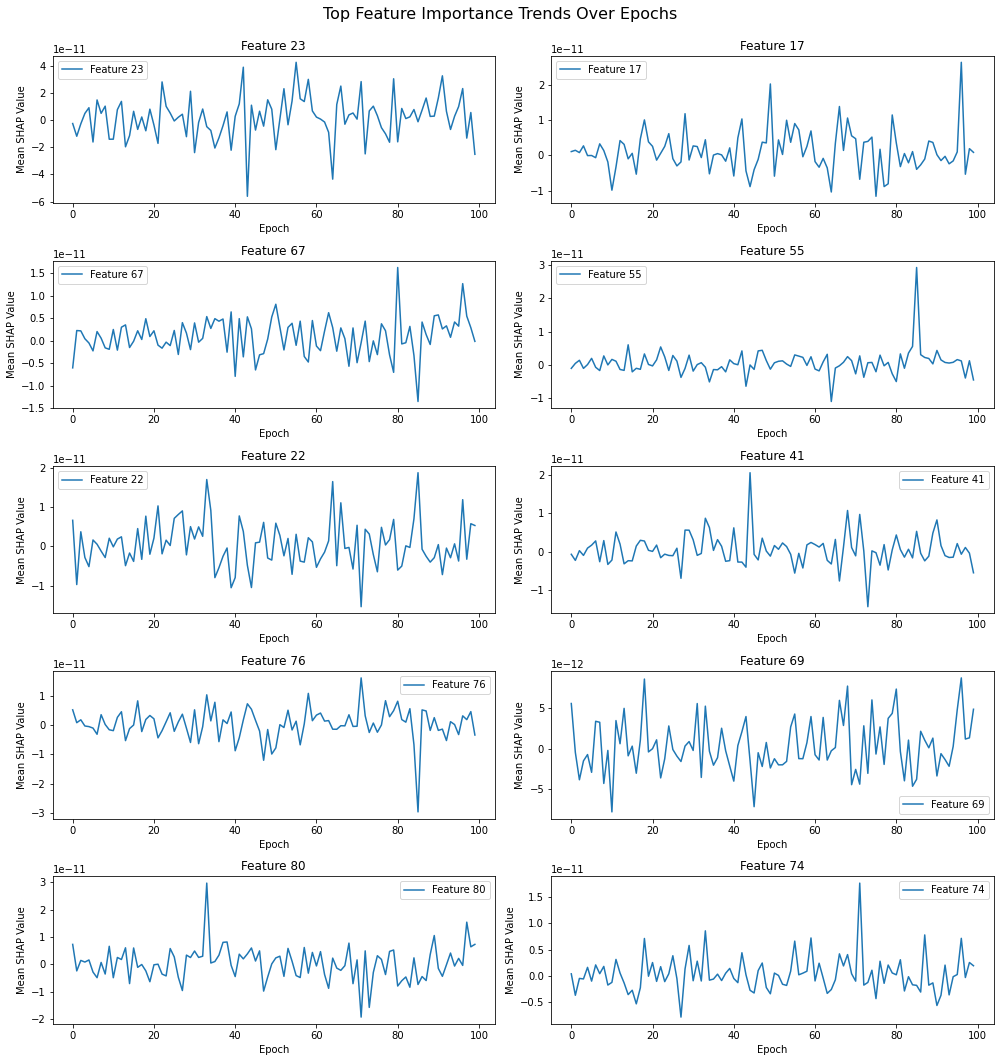

T-statistic: 1.4322220968977006, P-value: 0.15239339182380682
Fail to reject null hypothesis: No evidence of anchoring bias.
Feature: Feature 23, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 23: No evidence of bias.
Feature: Feature 17, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 17: No evidence of bias.
Feature: Feature 67, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 67: No evidence of bias.
Feature: Feature 55, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 55: No evidence of bias.
Feature: Feature 22, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 22: No evidence of bias.
Feature: Feature 41, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 41: No evidence of bias.
Feature: Feature 76, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 76: No evidence of bias.
Feature: Feature 69, Corrected P-value: 1.0
Fail to reject null hypothesis for Feature 69: 

In [55]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def analyze_shap_values(shap_values_history, top_n=10, correction_method='bonferroni'):
    # Determine the number of features from shap_values_history
    if shap_values_history:
        _, sample_shap_values = shap_values_history[0]
        num_features = sample_shap_values[0].shape[1]
    else:
        raise ValueError("shap_values_history is empty")

    feature_names = [f"Feature {i}" for i in range(num_features)]
    epochs = []
    feature_importances = {feature: [] for feature in feature_names}

    for epoch, shap_values in shap_values_history:
        epochs.append(epoch)
        mean_shap_values = np.mean(shap_values[0], axis=0)  # Assuming regression, for classification use shap_values[1]
        for i, feature in enumerate(feature_names):
            feature_importances[feature].append(mean_shap_values[i])

    # Calculate mean and variance of SHAP values for each feature
    feature_stats = {
        feature: {
            'mean': np.mean(importances),
            'variance': np.var(importances)
        } for feature, importances in feature_importances.items()
    }

    # Select top N features by mean SHAP value
    top_features = sorted(feature_stats.items(), key=lambda x: x[1]['mean'], reverse=True)[:top_n]
    top_feature_names = [feature for feature, _ in top_features]

    # Plot top N feature importance trends
    plt.figure(figsize=(12, 8))
    for feature in top_feature_names:
        plt.plot(epochs, feature_importances[feature], label=feature)
    plt.xlabel('Epoch')
    plt.ylabel('Mean SHAP Value')
    plt.title('Top Feature Importance Trends Over Epochs')
    plt.legend()
    plt.show()

    # Subplots for better visualization
    fig, axs = plt.subplots(top_n // 2, 2, figsize=(14, top_n * 1.5))
    fig.suptitle('Top Feature Importance Trends Over Epochs', fontsize=16)
    axs = axs.flatten()
    for i, feature in enumerate(top_feature_names):
        axs[i].plot(epochs, feature_importances[feature], label=feature)
        axs[i].set_title(feature)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Mean SHAP Value')
        axs[i].legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Statistical analysis for Anchoring Bias
    initial_features = top_feature_names[:5]  # Assume the first 5 of the top features are initial features
    other_features = top_feature_names[5:]

    initial_shap_values = [feature_importances[feature] for feature in initial_features]
    other_shap_values = [feature_importances[feature] for feature in other_features]

    initial_shap_values = np.array(initial_shap_values).flatten()
    other_shap_values = np.array(other_shap_values).flatten()

    t_stat, p_value = ttest_ind(initial_shap_values, other_shap_values)
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

    if p_value < 0.05:
        print("Reject null hypothesis: There is evidence of anchoring bias.")
    else:
        print("Fail to reject null hypothesis: No evidence of anchoring bias.")

    # Multiple hypothesis testing correction
    p_values = [ttest_ind(feature_importances[f], other_shap_values)[1] for f in top_feature_names]
    _, corrected_p_values, _, _ = multipletests(p_values, method=correction_method)

    for feature, p_val in zip(top_feature_names, corrected_p_values):
        print(f"Feature: {feature}, Corrected P-value: {p_val}")
        if p_val < 0.05:
            print(f"Reject null hypothesis for {feature}: There is evidence of bias.")
        else:
            print(f"Fail to reject null hypothesis for {feature}: No evidence of bias.")

# Analyze SHAP values history for cognitive biases
analyze_shap_values(shap_values_history, top_n=10, correction_method='bonferroni')
